**Dataset**: The dataset from Crunchbase shows characteristics of different companies that were funded all the way from the start of the 20th Century. Each company is labelled either as "closed", "operating" or "acquired"

**Context**: As per our investigation, 90%+ of startups fail in North America, with similar rates all over the world. However, from those that do succeeed, 85% have been acquired. As a result, "acquisition" we aim to understand the variables/characteristics that increases the likelihood of a startup being acquired where Success = Acquired / Failure = Not Acquired

**Scope**: For the scope of this investigation, we will concentrate on acquisitions in the 21st Century (>1999). This will provide more value to our investigation as the business world has changed a lot since the "pre .com" era


| **Column Name**        | **Description**                                                                          |
| ---------------------- | ---------------------------------------------------------------------------------------- |
| `permalink`            | Unique identifier (URL-style) for each company or startup.                               |
| `name`                 | Name of the company or organization.                                                     |
| `homepage_url`         | Official website or homepage of the company.                                             |
| `category_list`        | Industry category or business domain the company belongs to (e.g., FinTech, HealthTech). |
| `market`               | Specific market segment within the broader category.                                     |
| `funding_total_usd`    | Total funding received by the company (in USD).                                          |
| `status`               | Operational status (e.g., operating, acquired, closed, IPO).                             |
| `country_code`         | 3-letter ISO country code of the company’s headquarters (e.g., USA, GBR, CAN).           |
| `state_code`           | Regional or state code (mainly for U.S. companies).                                      |
| `region`               | Broader geographic region of operation (e.g., North America, Europe).                    |
| `city`                 | City where the company is based.                                                         |
| `funding_rounds`       | Number of funding rounds the company has completed.                                      |
| `founded_at`           | Exact founding date of the company (YYYY-MM-DD).                                         |
| `founded_month`        | Month in which the company was founded.                                                  |
| `founded_quarter`      | Quarter in which the company was founded (e.g., Q1, Q2).                                 |
| `founded_year`         | Year the company was founded.                                                            |
| `first_funding_at`     | Date when the company received its first funding.                                        |
| `last_funding_at`      | Date when the company received its most recent funding.                                  |
| `seed`                 | Total amount raised in seed-stage funding.                                               |
| `venture`              | Total amount raised through venture capital funding.                                     |
| `equity_crowdfunding`  | Amount raised via online equity crowdfunding platforms.                                  |
| `undisclosed`          | Funding amount that was reported but not disclosed publicly.                             |
| `convertible_note`     | Amount raised through convertible notes (debt that converts to equity).                  |
| `debt_financing`       | Amount raised via loans or traditional debt instruments.                                 |
| `angel`                | Amount raised from angel investors.                                                      |
| `grant`                | Amount received through grants or non-dilutive funding sources.                          |
| `private_equity`       | Amount raised from private equity firms.                                                 |
| `post_ipo_equity`      | Amount raised from issuing additional shares after going public.                         |
| `post_ipo_debt`        | Amount raised through debt financing after going public.                                 |
| `secondary_market`     | Amount raised from secondary market transactions.                                        |
| `product_crowdfunding` | Amount raised through product-based crowdfunding platforms (e.g., Kickstarter).          |
| `round_A` to `round_H` | Amounts raised in each specific investment round (A, B, C, D, E, F, G, H).               |


## Importing Packages

In [36]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import RocCurveDisplay, roc_auc_score, accuracy_score, precision_score, recall_score, confusion_matrix
import seaborn as sns

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF

from ISLP import load_data
from ISLP.models import (ModelSpec as MS,
                         summarize,
                         poly)

from ISLP import confusion_table


## Reading Data

In [37]:
investments = pd.read_csv("investments_VC.csv", encoding="latin1",dtype={"funding_total_usd":"string"})
investments.head()

,permalink,name,homepage_url,category_list,market,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,founded_month,founded_quarter,founded_year,first_funding_at,last_funding_at,seed,venture,equity_crowdfunding,undisclosed,convertible_note,debt_financing,angel,grant,private_equity,post_ipo_equity,post_ipo_debt,secondary_market,product_crowdfunding,round_A,round_B,round_C,round_D,round_E,round_F,round_G,round_H
0,/organization/waywire,#waywire,http://www.waywire.com,|Entertainment|Politics|Social Media|News|,News,"17,50,000",acquired,USA,NY,New York City,New York,1.0,2012-06-01,2012-06,2012-Q2,2012.0,2012-06-30,2012-06-30,1750000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,/organization/tv-communications,&TV Communications,http://enjoyandtv.com,|Games|,Games,"40,00,000",operating,USA,CA,Los Angeles,Los Angeles,2.0,NaN,NaN,NaN,NaN,2010-06-04,2010-09-23,0.0,4000000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,/organization/rock-your-paper,'Rock' Your Paper,http://www.rockyourpaper.org,|Publishing|Education|,Publishing,"40,000",operating,EST,NaN,Tallinn,Tallinn,1.0,2012-10-26,2012-10,2012-Q4,2012.0,2012-08-09,2012-08-09,40000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,/organization/in-touch-network,(In)Touch Network,http://www.InTouchNetwork.com,|Electronics|Guides|Coffee|Restaurants|Music|i...,Electronics,"15,00,000",operating,GBR,NaN,London,London,1.0,2011-04-01,2011-04,2011-Q2,2011.0,2011-04-01,2011-04-01,1500000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,/organization/r-ranch-and-mine,-R- Ranch and Mine,NaN,|Tourism|Entertainment|Games|,Tourism,"60,000",operating,USA,TX,Dallas,Fort Worth,2.0,2014-01-01,2014-01,2014-Q1,2014.0,2014-08-17,2014-09-26,0.0,0.0,60000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [38]:
# Remove irrelevant data from DataFrame outside the scope of the investigation (only companies founded in or after 2000)

investments_2000 = investments[investments['founded_year'].ge(2000)].copy()

#Strip column whitespace
investments_2000.columns = investments_2000.columns.str.strip()

print("Rows remaining after filter:", investments_2000.shape[0])
print("Columns:", investments_2000.shape[1])


Rows remaining after filter: 34823
Columns: 39


## EDA

In [39]:
print(investments_2000.columns.to_list())

print("\nThe number of companies of each status: \n")
print(investments_2000['status'].value_counts())

print("\nThe data types are: \n")
print(investments_2000.dtypes)

print("\n The shape is: \n")
print(investments_2000.shape)

print("\n The info is: \n")
print(investments_2000.info())

print("\n The null values per column are: \n")
print(investments_2000.isna().sum())


num_complete_rows = investments_2000.notna().all(axis=1).sum()
print(f"\nThe number of rows with no null values is: {num_complete_rows}")


earliest_founded = min(investments_2000['founded_year'])
latest_founded = max(investments_2000['founded_year'])
print(f"\n The earliest founded year is: {earliest_founded}")
print(f"\n The latest founded year is: {latest_founded}")

['permalink', 'name', 'homepage_url', 'category_list', 'market', 'funding_total_usd', 'status', 'country_code', 'state_code', 'region', 'city', 'funding_rounds', 'founded_at', 'founded_month', 'founded_quarter', 'founded_year', 'first_funding_at', 'last_funding_at', 'seed', 'venture', 'equity_crowdfunding', 'undisclosed', 'convertible_note', 'debt_financing', 'angel', 'grant', 'private_equity', 'post_ipo_equity', 'post_ipo_debt', 'secondary_market', 'product_crowdfunding', 'round_A', 'round_B', 'round_C', 'round_D', 'round_E', 'round_F', 'round_G', 'round_H']

The number of companies of each status: 

status
operating    29776
acquired      2376
closed        1894
Name: count, dtype: int64

The data types are: 

permalink                object
name                     object
homepage_url             object
category_list            object
market                   object
funding_total_usd        object
status                   object
country_code             object
state_code            

In [40]:
total_missing = investments_2000.isna().sum().sum()
total_elements = investments_2000.size
missing_percentage_total = (total_missing / total_elements) * 100
print(f"Percentage of missing values in the whole DataFrame: {missing_percentage_total:.2f}%")

Percentage of missing values in the whole DataFrame: 2.05%


In [41]:
num_duplicates = investments_2000.duplicated().sum()
num_rows = investments_2000.shape[0]
duplicate_percentage = (num_duplicates / num_rows) * 100
print(f"Percentage of duplicate rows in the DataFrame: {duplicate_percentage:.2f}%")

Percentage of duplicate rows in the DataFrame: 0.00%


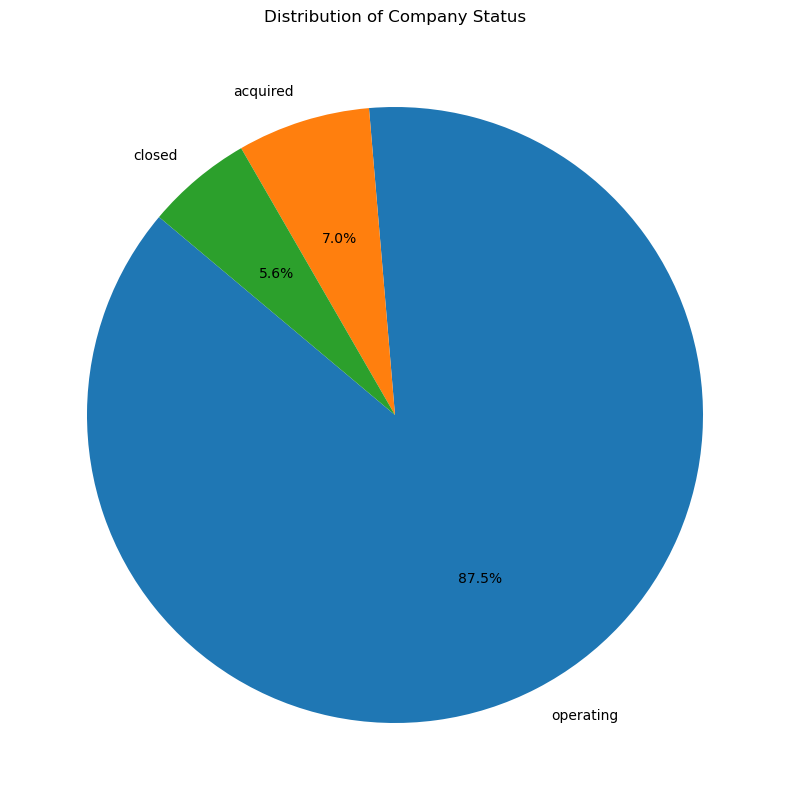

In [42]:
status_counts = investments_2000['status'].value_counts()

# Pie chart
plt.figure(figsize=(10, 10), facecolor='none') # Set figure facecolor to none for transparency
plt.pie(status_counts, labels=status_counts.index, autopct='%1.1f%%', startangle=140, textprops={'color':"black"}) # Set text color to white
plt.title('Distribution of Company Status', color='black') # Set title color to white
#plt.savefig('Status_Pie_Chart.png', transparent=True, dpi=300) # Save as PNG with transparent background and 300 dpi
plt.show()

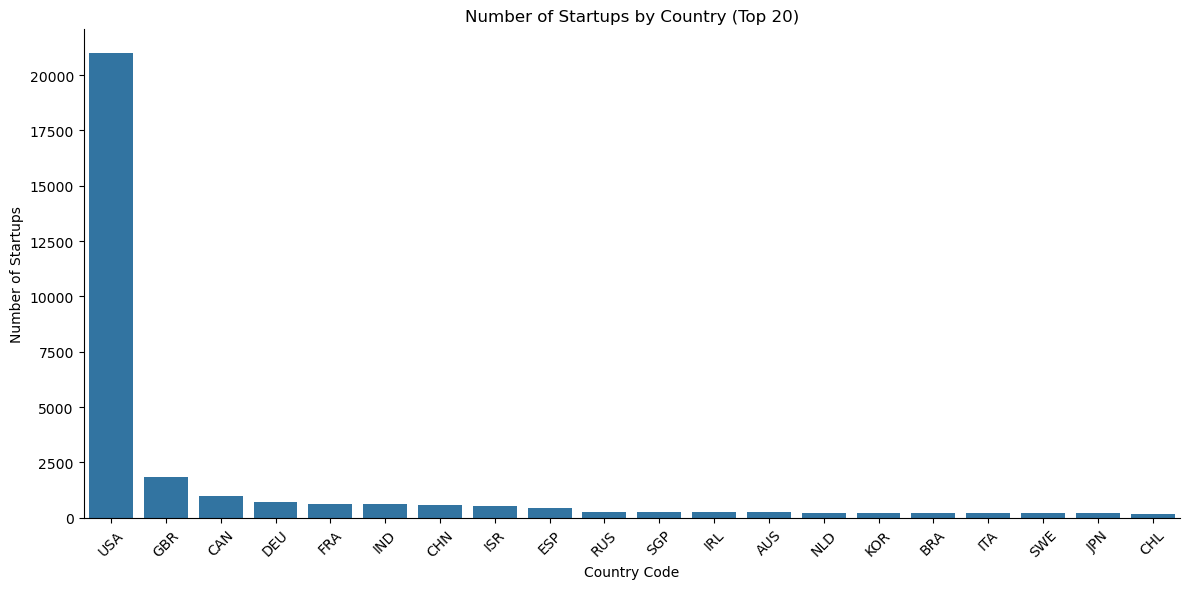

In [43]:
country_counts = investments_2000['country_code'].value_counts().head(20) # Displaying top 20 countries for clarity

plt.figure(figsize=(12, 6))
ax = sns.barplot(x=country_counts.index, y=country_counts.values)
plt.title('Number of Startups by Country (Top 20)', color='black') # Changed color to black
plt.xlabel('Country Code', color='black') # Changed color to black
plt.ylabel('Number of Startups', color='black') # Changed color to black
plt.xticks(rotation=45, color='black') # Changed color to black
plt.yticks(color='black') # Changed color to black
ax.spines['bottom'].set_color('black') # Changed color to black
ax.spines['left'].set_color('black') # Changed color to black
ax.spines['right'].set_visible(False) # Remove right spine
ax.spines['top'].set_visible(False) # Remove top spine
ax.tick_params(axis='x', colors='black') # Changed color to black
ax.tick_params(axis='y', colors='black') # Changed color to black

plt.tight_layout()
#plt.savefig('Startups_by_country4.png', transparent=True, dpi=300)

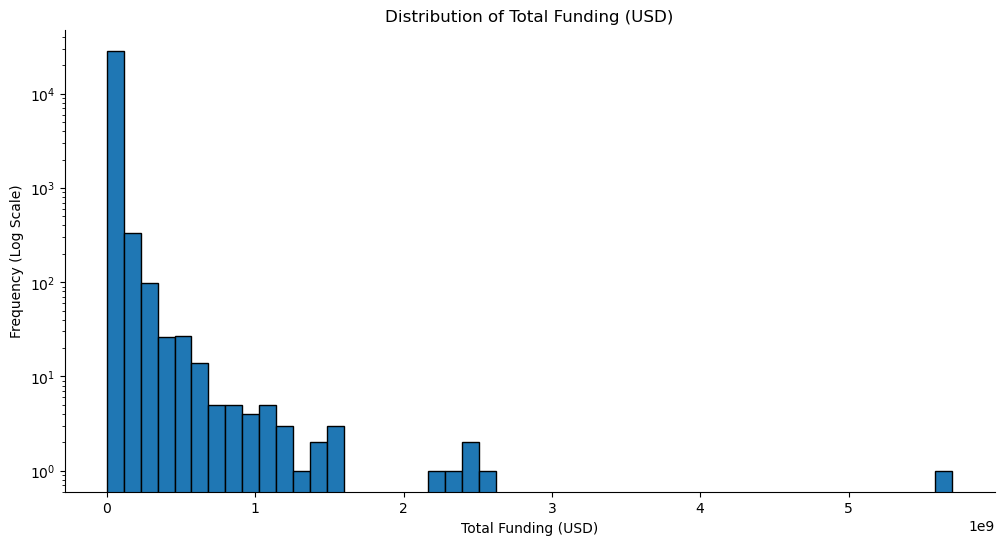

In [44]:
# Clean the ' funding_total_usd ' column
investments_2000['funding_total_usd'] = investments_2000['funding_total_usd'].astype(str).str.replace(',', '', regex=False)
investments_2000['funding_total_usd'] = pd.to_numeric(investments_2000['funding_total_usd'], errors='coerce')

# Drop rows with NaN values in ' funding_total_usd ' after coercion
df_cleaned = investments_2000.dropna(subset=['funding_total_usd'])

# Create the histogram with log scale on y-axis
plt.figure(figsize=(12, 6))
ax = plt.hist(df_cleaned['funding_total_usd'], bins=50, edgecolor='black')
plt.yscale('log') # Set y-axis to log scale
plt.title('Distribution of Total Funding (USD)', color='black')
plt.xlabel('Total Funding (USD)', color='black')
plt.ylabel('Frequency (Log Scale)', color='black')
plt.xticks(color='black')
plt.yticks(color='black')

# Get the axes object to modify spines
ax = plt.gca()
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.spines['right'].set_visible(False) # Remove right spine
ax.spines['top'].set_visible(False) # Remove top spine
ax.tick_params(axis='x', colors='black')
ax.tick_params(axis='y', colors='black')

#plt.savefig('Funding_Distribution_Histogram2.png')
plt.show()



 The features that are highly correlated are: 

            Feature1         Feature2  Correlation
110          venture          round_D     0.614847
288  post_ipo_equity    post_ipo_debt     0.698361
311    post_ipo_debt  post_ipo_equity     0.698361
441          round_D          venture     0.614847
528          round_G          round_H     0.859849
551          round_H          round_G     0.859849


[None, None, None, None, None, None, None, None]

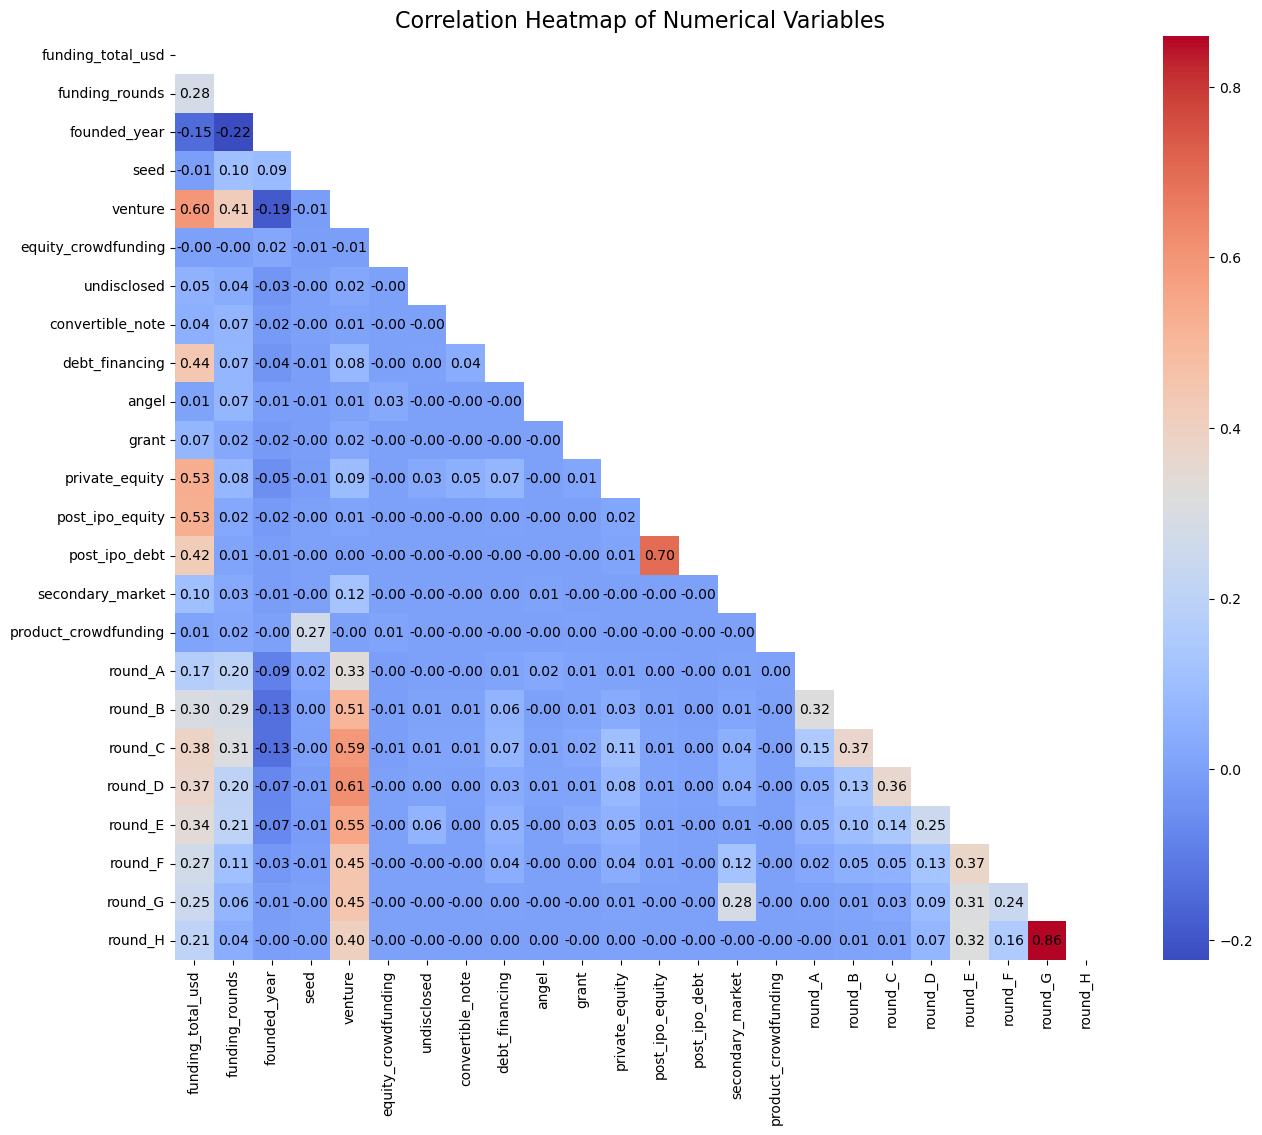

In [45]:
# 1. Calculate Shared Variables (Correlation Matrix)
numeric_cols = investments_2000.select_dtypes(include='number').columns
corr_matrix = investments_2000[numeric_cols].corr()

# 2. Correlation Reporting (Finding Highly Correlated Pairs)
# Remove self-correlations by masking the diagonal
mask_report = np.eye(len(corr_matrix), dtype=bool)
corr_matrix_no_diag = corr_matrix.mask(mask_report)

# Find high correlations
high_corr = corr_matrix_no_diag.stack().reset_index()
high_corr.columns = ['Feature1', 'Feature2', 'Correlation']
high_corr = high_corr[abs(high_corr['Correlation']) > 0.6]

print("\n The features that are highly correlated are: \n")
print(high_corr)


# 3. Correlation Plotting (Generating Heatmap)
# Create a mask for the upper triangle (to clean up the plot)
mask_plot = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Create a heatmap with the mask
plt.figure(figsize=(15, 12))
ax = sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", mask=mask_plot, annot_kws={"color": "black"}, cbar_kws={"use_gridspec": False, "location": "right"})
plt.title('Correlation Heatmap of Numerical Variables', color='black', fontsize=16)
plt.xticks(color='black')
plt.yticks(color='black')

# Change colorbar text color
cbar = ax.collections[0].colorbar
cbar.ax.yaxis.set_tick_params(color='black')
plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='black')

#plt.savefig('Correlation_Heatmap3.png', transparent=True, dpi=300)

### Chosing relevant columns

**Comment**: There are 39 columns. However only some of these will be relevant to the investigation. We will be removing:

- Metadata: "Permalink", "homepage_url" -> These add no value to our model.
- Irrelevant data: "founded_month","founded_quarter" -> Whether a company was founded in March or December would not explain its success. These attributes are repeated each year and we cant treat October of 1950 the same as October of 2010. These will be removed, and instead "founded_year" will be considered
- Aggregated Data: Funding_total_usd is the sum of column "round a" + ... + "round h". As a result, only Funding_total_USD will be kept, and we will drop the pieces that sum to the total
   
For now, we will keep the following relevant columns: "state_code","market", "funding_total_usd", "country_code", "city", "founded_year", "first_funding_at","last_funding_at", and "status"

Note: While the original dataset includes entries from multiple countries, this investigation will focus exclusively on the United States. Macroeconomic conditions vary significantly across regions so by doing so we are limiting distortion in our data. Also, given that the U.S. serves as a central hub for startup activity, it represents our primary area of interest.

In [46]:
# Extracting relevant columns into new dataset investments_subset 
investments_2000.columns = investments_2000.columns.str.strip()  # removing any potential extra spaces from column names

relevant_cols = ["permalink",
    "state_code",
    "funding_total_usd",
    "founded_year",
    "first_funding_at",
    "last_funding_at",  
    "status",
    "market",
]

# Keep only those columns
investments_subset = investments_2000[relevant_cols].copy()
investments_subset.head()


,permalink,state_code,funding_total_usd,founded_year,first_funding_at,last_funding_at,status,market
0,/organization/waywire,NY,1750000.0,2012.0,2012-06-30,2012-06-30,acquired,News
2,/organization/rock-your-paper,NaN,40000.0,2012.0,2012-08-09,2012-08-09,operating,Publishing
3,/organization/in-touch-network,NaN,1500000.0,2011.0,2011-04-01,2011-04-01,operating,Electronics
4,/organization/r-ranch-and-mine,TX,60000.0,2014.0,2014-08-17,2014-09-26,operating,Tourism
5,/organization/club-domains,FL,7000000.0,2011.0,2013-05-31,2013-05-31,NaN,Software


In [47]:
## Checking size and missing values for investments_subset
subset_shape = investments_subset.shape
null_data_exist_subset = investments_subset.isnull().values.any()
null_data_count_subset = investments_subset.isnull().values.sum()

print('Size of investments_subset data is:', subset_shape)
print('Does investments_subset have missing values?:', null_data_exist_subset)
investments_subset.isnull().sum().sort_values(ascending=False).head(10)


Size of investments_subset data is: (34823, 8)
Does investments_subset have missing values?: True


state_code           12850
funding_total_usd     5741
market                1671
status                 777
permalink                0
founded_year             0
first_funding_at         0
last_funding_at          0
dtype: int64

#### Chosing relevant rows

Missing values:
- State_code: Missing data in this category are because a small subset of data are non-US companies. These will be filtered
- Status and market: Missing values represent <5% of data. They will be dropped. Values missing states are outside of our scope as they are non US companies so those can also be dropped


In [48]:
problem_count = investments[
    (investments['country_code'] == 'USA') &  
    (investments['state_code'].isna())        
].shape[0]

print(f"Number of USA companies with missing state codes: {problem_count}")

# Dropping Missing Values 
investments_subset = investments_subset.dropna().copy()
print("New dataset size:", investments_subset.shape)




Number of USA companies with missing state codes: 26
New dataset size: (17815, 8)


#### Preparing Categorical Data for Analysis

Two of our explanatory variables have a lot of distinct data which would lead to a vast amount of dummy variables, making it messy and not super useful statistically. We will bin these data into identifiable groups. For instance:

- State: To reduce dimensionality in the model and improve interpretability, the 50 U.S. states are grouped based on their Business-friendly Index as per the trusted 2024 Tax Foundation State Business Tax Climate Index. This provides value in explaining which states provide the best environment for a start up to be acquired. 
- Market: We condensed the markets into a smaller set of broader industry groups to avoid creating too many dummy variables, which would slow down the model and cause memory issues. For example, instead of treating “Software,” “Enterprise Software,” and “SaaS” as separate categories, we combined them into one Software & IT group, helping us reduce 35+ industries down to 7.

In [49]:
#Grouping States
investments_subset['state_code'] = investments_subset['state_code'].str.strip()

# 2014 State Business Tax Climate Index tiers
# Tier 1 (1–15): Business_Friendly
# Tier 2 (16–35): Moderate
# Tier 3 (36–50): High_Regulation

business_groups = {
    # Tier 1 — Business_Friendly (ranks 1–15 in 2014)
    'WY':'Business_Friendly','SD':'Business_Friendly','NV':'Business_Friendly','AK':'Business_Friendly',
    'FL':'Business_Friendly','MT':'Business_Friendly','UT':'Business_Friendly','NH':'Business_Friendly',
    'OR':'Business_Friendly','IN':'Business_Friendly','MI':'Business_Friendly','TX':'Business_Friendly',
    'WA':'Business_Friendly','MO':'Business_Friendly','ID':'Business_Friendly',

    # Tier 2 — Moderate (ranks 16–35 in 2014)
    'VA':'Moderate','WV':'Moderate','DE':'Moderate','ND':'Moderate','OK':'Moderate','NM':'Moderate',
    'KS':'Moderate','CO':'Moderate','TN':'Moderate','MS':'Moderate','MA':'Moderate','AZ':'Moderate',
    'GA':'Moderate','KY':'Moderate','LA':'Moderate','ME':'Moderate','IL':'Moderate','NC':'Moderate',
    'SC':'Moderate','WI':'Moderate',

    # Tier 3 — High_Regulation (ranks 36–50 in 2014)
    'NE':'High_Regulation','AL':'High_Regulation','AR':'High_Regulation','CA':'High_Regulation',
    'CT':'High_Regulation','HI':'High_Regulation','IA':'High_Regulation','MD':'High_Regulation',
    'MN':'High_Regulation','NJ':'High_Regulation','NY':'High_Regulation','OH':'High_Regulation',
    'PA':'High_Regulation','RI':'High_Regulation','VT':'High_Regulation',
    'DC':'High_Regulation'
}


investments_subset['state_code'] = investments_subset['state_code'].map(business_groups).fillna('Other')

#Grouping markets

# Grouping Markets into Buckets

investments_subset['market'] = investments_subset['market'].str.strip()
bucket_mapping = {
    # Tier 1 - Media & Entertainment
    'News':'Media & Entertainment', 'Games':'Media & Entertainment', 'Publishing':'Media & Entertainment',
    'Advertising':'Media & Entertainment', 'Curated Web':'Media & Entertainment', 'Social Travel':'Media & Entertainment',
    'Sports':'Media & Entertainment', 'Chat':'Media & Entertainment', 'Video Chat':'Media & Entertainment',
    'Social Media':'Media & Entertainment', 'Photography':'Media & Entertainment', 'Art':'Media & Entertainment',
    'Blogging Platforms':'Media & Entertainment', 'Mobile Social':'Media & Entertainment', 'Messaging':'Media & Entertainment',
    'Mobile Games':'Media & Entertainment', 'Social Games':'Media & Entertainment', 'Communities':'Media & Entertainment',
    'Social Network Media':'Media & Entertainment', 'Digital Media':'Media & Entertainment', 'Social Bookmarking':'Media & Entertainment',
    'Content Syndication':'Media & Entertainment', 'Broadcasting':'Media & Entertainment', 'Opinions':'Media & Entertainment',
    'Content':'Media & Entertainment', 'Content Creators':'Media & Entertainment', 'Social + Mobile + Local':'Media & Entertainment',
    'Video Streaming':'Media & Entertainment', 'Photo Sharing':'Media & Entertainment', 'Video':'Media & Entertainment',
    'Music':'Media & Entertainment', 'Game':'Media & Entertainment', 'Entertainment':'Media & Entertainment',
    'Digital Entertainment':'Media & Entertainment', 'Virtual Worlds':'Media & Entertainment', 'Television':'Media & Entertainment',
    'Social Media Platforms':'Media & Entertainment', 'Internet Radio Market':'Media & Entertainment', 'E-Books':'Media & Entertainment',
    'Forums':'Media & Entertainment', 'Private Social Networking':'Media & Entertainment', 'Social News':'Media & Entertainment',
    'Politics':'Media & Entertainment', 'MicroBlogging':'Media & Entertainment', 'Celebrity':'Media & Entertainment',
    'Artists Globally':'Media & Entertainment', 'Religion':'Media & Entertainment', 'Theatre':'Media & Entertainment',
    'Independent Music Labels':'Media & Entertainment', 'Q&A':'Media & Entertainment', 'Concerts':'Media & Entertainment',
    'Film Distribution':'Media & Entertainment', 'TV Production':'Media & Entertainment', 'Internet TV':'Media & Entertainment',
    'Musical Instruments':'Media & Entertainment', 'Racing':'Media & Entertainment', 'Swimming':'Media & Entertainment',
    'Social Television':'Media & Entertainment', 'Comics':'Media & Entertainment', 'FreetoPlay Gaming':'Media & Entertainment',
    'Musicians':'Media & Entertainment', 'Mobile Video':'Media & Entertainment', 'Cloud-Based Music':'Media & Entertainment',
    'SNS':'Media & Entertainment', 'Performing Arts':'Media & Entertainment', 'Contests':'Media & Entertainment',
    'Music Venues':'Media & Entertainment', 'Email Newsletters':'Media & Entertainment', 'Writers':'Media & Entertainment',
    'Social Opinion Platform':'Media & Entertainment', 'Reading Apps':'Media & Entertainment', 'EBooks':'Media & Entertainment',
    'Video Games':'Media & Entertainment', 'Film Production':'Media & Entertainment', 'Music Services':'Media & Entertainment',
    'MMO Games':'Media & Entertainment', 'Fantasy Sports':'Media & Entertainment', 'Gambling':'Media & Entertainment',
    'Game Mechanics':'Media & Entertainment', 'Content Discovery':'Media & Entertainment', 'Soccer':'Media & Entertainment',
    'In-Flight Entertainment':'Media & Entertainment', 'Casual Games':'Media & Entertainment', 'Entertainment Industry':'Media & Entertainment',
    'Educational Games':'Media & Entertainment', 'PC Gaming':'Media & Entertainment', 'Film':'Media & Entertainment',
    'Journalism':'Media & Entertainment', 'Guides':'Media & Entertainment', 'Audio':'Media & Entertainment',
    'Online Gaming':'Media & Entertainment', 'Video on Demand':'Media & Entertainment', 'Video Processing':'Media & Entertainment',
    'Smart Grid':'Media & Entertainment', 'Charter Schools':'Media & Entertainment', 'Radical Breakthrough Startups':'Media & Entertainment',
    'Social Business':'Media & Entertainment', 'Social Innovation':'Media & Entertainment', 'Startups':'Media & Entertainment',
    'Smart Building':'Media & Entertainment', 'Social Commerce':'Media & Entertainment', 'Social Buying':'Media & Entertainment',
    'Online Video Advertising':'Media & Entertainment',

    # Tier 2 - Technology & Software
    'Software':'Technology & Software', 'Health Care Information Technology':'Technology & Software', 'Analytics':'Technology & Software',
    'Mobile':'Technology & Software', 'SaaS':'Technology & Software', 'Enterprise Software':'Technology & Software',
    'File Sharing':'Technology & Software', 'Mobile Security':'Technology & Software', 'Predictive Analytics':'Technology & Software',
    'Big Data':'Technology & Software', 'Hardware + Software':'Technology & Software', 'Corporate IT':'Technology & Software',
    'Web Development':'Technology & Software', '3D Printing':'Technology & Software', '3D':'Technology & Software',
    '3D Technology':'Technology & Software', 'Drones':'Technology & Software', 'Semiconductors':'Technology & Software',
    'Web Hosting':'Technology & Software', 'Android':'Technology & Software', 'Developer APIs':'Technology & Software',
    'Security':'Technology & Software', 'Flash Storage':'Technology & Software', 'Networking':'Technology & Software',
    'Machine Learning':'Technology & Software', 'Web Design':'Technology & Software', 'Cloud Computing':'Technology & Software',
    'Interface Design':'Technology & Software', 'Technology':'Technology & Software', 'Telecommunications':'Technology & Software',
    'Twitter Applications':'Technology & Software', 'Business Productivity':'Technology & Software', 'Communications Hardware':'Technology & Software',
    'EDA Tools':'Technology & Software', 'Virtualization':'Technology & Software', 'Cloud Infrastructure':'Technology & Software',
    'M2M':'Technology & Software', 'Identity Management':'Technology & Software', 'Information Security':'Technology & Software',
    'Apps':'Technology & Software', 'Information Technology':'Technology & Software', 'Medical Devices':'Technology & Software',
    'Cloud Management':'Technology & Software', 'Vertical Search':'Technology & Software', 'Internet of Things':'Technology & Software',
    'Semantic Search':'Technology & Software', 'Internet':'Technology & Software', 'Business Intelligence':'Technology & Software',
    'Email':'Technology & Software', 'Development Platforms':'Technology & Software', 'Semantic Web':'Technology & Software',
    'Collaboration':'Technology & Software', 'Assisitive Technology':'Technology & Software', 'Facebook Applications':'Technology & Software',
    'Location Based Services':'Technology & Software', 'Trusted Networks':'Technology & Software', 'Data Visualization':'Technology & Software',
    'Enterprise Search':'Technology & Software', 'Optimization':'Technology & Software', 'Application Platforms':'Technology & Software',
    'Computers':'Technology & Software', 'Real Time':'Technology & Software', 'Digital Signage':'Technology & Software',
    'RIM':'Technology & Software', 'Databases':'Technology & Software', 'Displays':'Technology & Software',
    'Meeting Software':'Technology & Software', 'Retail Technology':'Technology & Software', 'Tablets':'Technology & Software',
    'Gps':'Technology & Software', 'Web CMS':'Technology & Software', 'Sensors':'Technology & Software',
    'iPhone':'Technology & Software', 'Human Computer Interaction':'Technology & Software', 'Local Search':'Technology & Software',
    'Computer Vision':'Technology & Software', 'Cloud Security':'Technology & Software', 'Credit':'Technology & Software',
    'Document Management':'Technology & Software', 'Data Mining':'Technology & Software', 'Linux':'Technology & Software',
    'App Stores':'Technology & Software', 'Open Source':'Technology & Software', 'iPad':'Technology & Software',
    'Big Data Analytics':'Technology & Software', 'Data Integration':'Technology & Software', 'College Recruiting':'Technology & Software',
    'Knowledge Management':'Technology & Software', 'Social Media Monitoring':'Technology & Software', 'Portals':'Technology & Software',
    'Graphics':'Technology & Software', 'Mobile Software Tools':'Technology & Software', 'Enterprise Security':'Technology & Software',
    'Mobile Enterprise':'Technology & Software', 'Homeland Security':'Technology & Software', 'Mobile Devices':'Technology & Software',
    'Developer Tools':'Technology & Software', 'PaaS':'Technology & Software', 'Application Performance Monitoring':'Technology & Software',
    'Testing':'Technology & Software', 'User Experience Design':'Technology & Software', 'QR Codes':'Technology & Software',
    'Cyber Security':'Technology & Software', 'CRM':'Technology & Software', 'Enterprise Application':'Technology & Software',
    'Browser Extensions':'Technology & Software', 'Contact Management':'Technology & Software', 'Data Security':'Technology & Software',
    'Deep Information Technology':'Technology & Software', 'Augmented Reality':'Technology & Software', 'Universities':'Technology & Software',
    'Web Tools':'Technology & Software', 'Visualization':'Technology & Software', 'Physical Security':'Technology & Software',
    'Identity':'Technology & Software', 'Tracking':'Technology & Software', 'RFID':'Technology & Software',
    'E-Commerce Platforms':'Technology & Software', 'Productivity Software':'Technology & Software', 'NFC':'Technology & Software',
    'Content Delivery':'Technology & Software', 'Video Conferencing':'Technology & Software', 'Network Security':'Technology & Software',
    'VoIP':'Technology & Software', 'Storage':'Technology & Software', 'Social Search':'Technology & Software',
    'Peer-to-Peer':'Technology & Software', 'Project Management':'Technology & Software', 'Data Privacy':'Technology & Software',
    'Algorithms':'Technology & Software', 'IT and Cybersecurity':'Technology & Software', 'Biometrics':'Technology & Software',
    'High Tech':'Technology & Software', 'Enterprise Hardware':'Technology & Software', 'Infrastructure':'Technology & Software',
    'Data Centers':'Technology & Software', 'Image Recognition':'Technology & Software', 'IaaS':'Technology & Software',
    'Credit Cards':'Technology & Software', 'CAD':'Technology & Software', 'Ediscovery':'Technology & Software',
    'University Students':'Technology & Software', 'Customer Support Tools':'Technology & Software', 'Proximity Internet':'Technology & Software',
    'Tech Field Support':'Technology & Software', 'Text Analytics':'Technology & Software', 'Embedded Hardware and Software':'Technology & Software',
    'Bridging Online and Offline':'Technology & Software', 'Synchronization':'Technology & Software', 'Utilities':'Technology & Software',
    'Digital Rights Management':'Technology & Software', 'Communications Infrastructure':'Technology & Software', 'Systems':'Technology & Software',
    'Senior Citizens':'Technology & Software', 'Architecture':'Technology & Software', 'Google Apps':'Technology & Software',
    'Social Recruiting':'Technology & Software', 'WebOS':'Technology & Software', 'Natural Language Processing':'Technology & Software',
    'Windows Phone 7':'Technology & Software', 'New Product Development':'Technology & Software', 'Supply Chain Management':'Technology & Software',
    'Indoor Positioning':'Technology & Software', 'Usability':'Technology & Software', 'Domains':'Technology & Software',
    'Software Compliance':'Technology & Software', 'Registrars':'Technology & Software', 'App Discovery':'Technology & Software',
    'Motion Capture':'Technology & Software', 'Intelligent Systems':'Technology & Software', 'China Internet':'Technology & Software',
    'New Technologies':'Technology & Software', 'Point of Sale':'Technology & Software', 'Data Center Infrastructure':'Technology & Software',
    'Unmanned Air Systems':'Technology & Software', 'Business Information Systems':'Technology & Software', 'Commodities':'Technology & Software',
    'Speech Recognition':'Technology & Software', 'Face Recognition':'Technology & Software', 'ICT':'Technology & Software',
    'Self Development':'Technology & Software', 'Kinect':'Technology & Software', 'Web Browsers':'Technology & Software',
    'Presentations':'Technology & Software', 'Internet Service Providers':'Technology & Software', 'Rapidly Expanding':'Technology & Software',
    'Video Editing':'Technology & Software', 'Biotechnology and Semiconductor':'Technology & Software', 'Visual Search':'Technology & Software',
    'Internet Infrastructure':'Technology & Software', 'Cyber':'Technology & Software', 'Group SMS':'Technology & Software',
    'Lasers':'Technology & Software', 'Weird Hardware':'Technology & Software', 'Energy IT':'Technology & Software',
    'Mac':'Technology & Software', 'Renewable Tech':'Technology & Software', 'Enterprise 2.0':'Technology & Software',
    'Photo Editing':'Technology & Software', 'Google Glass':'Technology & Software', 'Mobile Infrastructure':'Technology & Software',
    'Data Center Automation':'Technology & Software', 'Personal Data':'Technology & Software', 'Internet Technology':'Technology & Software',
    'Fraud Detection':'Technology & Software', 'Quantitative Marketing':'Technology & Software', 'Online Identity':'Technology & Software',
    'Gadget':'Technology & Software', 'Early-Stage Technology':'Technology & Software', 'Simulation':'Technology & Software',
    'Test and Measurement':'Technology & Software', 'Automated Kiosk':'Technology & Software', 'Clean Technology IT':'Technology & Software',
    'Finance Technology':'Technology & Software', 'Mobile Analytics':'Technology & Software', 'Cloud Data Services':'Technology & Software',
    'Privacy':'Technology & Software', 'SMS':'Technology & Software', 'Artificial Intelligence':'Technology & Software',
    'Bitcoin':'Technology & Software', 'Navigation':'Technology & Software', 'Maps':'Technology & Software',
    'Nanotechnology':'Technology & Software', 'Mining Technologies':'Technology & Software', 'Nonprofits':'Technology & Software',
    'Recruiting':'Technology & Software', 'Advertising Platforms':'Technology & Software', 'Email Marketing':'Technology & Software',
    'Social CRM':'Technology & Software', 'Hardware':'Technology & Software', 'IT Management':'Technology & Software',
    'Charity':'Technology & Software', 'Employer Benefits Programs':'Technology & Software', 'Nutrition':'Technology & Software',
    'Sustainability':'Technology & Software', 'Non Profit':'Technology & Software', 'Venture Capital':'Technology & Software',
    'Search':'Technology & Software', 'Gamification':'Technology & Software', 'Fitness':'Technology & Software',
    'Retail':'Technology & Software', 'DOD/Military':'Technology & Software', 'Product Development Services':'Technology & Software',
    'Specialty Retail':'Technology & Software', 'Hospitals':'Technology & Software', 'Wireless':'Technology & Software',

    # Tier 3 - Business Services
    'Designers':'Business Services', 'Sales and Marketing':'Business Services', 'Services':'Business Services',
    'Outsourcing':'Business Services', 'Customer Service':'Business Services', 'Human Resources':'Business Services',
    'Entrepreneur':'Business Services', 'Business Services':'Business Services', 'Career Management':'Business Services',
    'Small and Medium Businesses':'Business Services', 'SEO':'Business Services', 'Task Management':'Business Services',
    'Public Relations':'Business Services', 'Consulting':'Business Services', 'Design':'Business Services',
    'Creative':'Business Services', 'Events':'Business Services', 'Brand Marketing':'Business Services',
    'Ad Targeting':'Business Services', 'Social Media Advertising':'Business Services', 'Lead Generation':'Business Services',
    'Online Scheduling':'Business Services', 'Outdoor Advertising':'Business Services', 'App Marketing':'Business Services',
    'Legal':'Business Services', 'Advice':'Business Services', 'Advertising Exchanges':'Business Services',
    'Business Development':'Business Services', 'Personal Branding':'Business Services', 'Crowdsourcing':'Business Services',
    'Information Services':'Business Services', 'Product Design':'Business Services', 'Enterprises':'Business Services',
    'BPO Services':'Business Services', 'Reputation':'Business Services', 'Training':'Business Services',
    'Loyalty Programs':'Business Services', 'Social Media Marketing':'Business Services', 'Freelancers':'Business Services',
    'Market Research':'Business Services', 'Service Providers':'Business Services', 'Professional Services':'Business Services',
    'Local Advertising':'Business Services', 'Creative Industries':'Business Services', 'Direct Marketing':'Business Services',
    'Consumer Behavior':'Business Services', 'Incubators':'Business Services', 'Coworking':'Business Services',
    'Career Planning':'Business Services', 'World Domination':'Business Services', 'Moneymaking':'Business Services',
    'Intellectual Property':'Business Services', 'Printing':'Business Services', 'Staffing Firms':'Business Services',
    'All Markets':'Business Services', 'Employment':'Business Services', 'Shared Services':'Business Services',
    'Governments':'Business Services', 'Engineering Firms':'Business Services', 'Professional Networking':'Business Services',
    'Ventures for Good':'Business Services', 'Procurement':'Business Services', 'Law Enforcement':'Business Services',
    'Funeral Industry':'Business Services', 'Freemium':'Business Services', 'Interior Design':'Business Services',
    'Skill Assessment':'Business Services', 'Innovation Management':'Business Services', 'Public Safety':'Business Services',
    'Polling':'Business Services', 'Humanitarian':'Business Services', 'Surveys':'Business Services',
    'Contact Centers':'Business Services', 'Human Resource Automation':'Business Services', 'Call Center Automation':'Business Services',
    'Innovation Engineering':'Business Services', 'Lifestyle Businesses':'Business Services', 'Offline Businesses':'Business Services',
    'Governance':'Business Services', 'Demographies':'Business Services', 'Homeless Shelter':'Business Services',
    'Government Innovation':'Business Services', 'Niche Specific':'Business Services', 'Web Presence Management':'Business Services',
    'Franchises':'Business Services', 'Social Media Agent':'Business Services', 'Enterprise Purchasing':'Business Services',
    'Estimation and Quoting':'Business Services', 'Multi-level Marketing':'Business Services', 'Service Industries':'Business Services',
    'Internet Marketing':'Business Services', 'Promotional':'Business Services', 'Search Marketing':'Business Services',
    'Mobile Advertising':'Business Services', 'Lead Management':'Business Services', 'Performance Marketing':'Business Services',
    'Advertising Networks':'Business Services', 'Civil Engineers':'Business Services', 'Translation':'Business Services',
    'Corporate Training':'Business Services', 'Sales Automation':'Business Services', 'Sponsorship':'Business Services',
    'Intellectual Asset Management':'Business Services', 'Event Management':'Business Services',

    # Tier 4 - Consumer & Retail
    'Electronics':'Consumer & Retail', 'E-Commerce':'Consumer & Retail', 'Marketplaces':'Consumer & Retail',
    'Restaurants':'Consumer & Retail', 'Fashion':'Consumer & Retail', 'Mobile Commerce':'Consumer & Retail',
    'Lifestyle':'Consumer & Retail', 'Wine And Spirits':'Consumer & Retail', 'Consumer Electronics':'Consumer & Retail',
    'Kids':'Consumer & Retail', 'Pets':'Consumer & Retail', 'Women':'Consumer & Retail',
    'Specialty Foods':'Consumer & Retail', 'Online Shopping':'Consumer & Retail', 'Coupons':'Consumer & Retail',
    'Collectibles':'Consumer & Retail', 'Classifieds':'Consumer & Retail', 'Auctions':'Consumer & Retail',
    'Comparison Shopping':'Consumer & Retail', 'Consumers':'Consumer & Retail', 'Shopping':'Consumer & Retail',
    'Match-Making':'Consumer & Retail', 'Online Rental':'Consumer & Retail', 'Groceries':'Consumer & Retail',
    'Weddings':'Consumer & Retail', 'Lighting':'Consumer & Retail', 'Craft Beer':'Consumer & Retail',
    'Craigslist Killers':'Consumer & Retail', 'Consumer Goods':'Consumer & Retail', 'Reviews and Recommendations':'Consumer & Retail',
    'Toys':'Consumer & Retail', 'Handmade':'Consumer & Retail', 'Online Dating':'Consumer & Retail',
    'Consumer Internet':'Consumer & Retail', 'Subscription Businesses':'Consumer & Retail', 'Ticketing':'Consumer & Retail',
    'Babies':'Consumer & Retail', 'Price Comparison':'Consumer & Retail', 'Group Buying':'Consumer & Retail',
    'Jewelry':'Consumer & Retail', 'Home Decor':'Consumer & Retail', 'Wholesale':'Consumer & Retail',
    'Farmers Market':'Consumer & Retail', 'Baby Accessories':'Consumer & Retail', 'Parenting':'Consumer & Retail',
    'Lifestyle Products':'Consumer & Retail', 'Discounts':'Consumer & Retail', 'Organic':'Consumer & Retail',
    'Collaborative Consumption':'Consumer & Retail', 'Organic Food':'Consumer & Retail', 'Low Bid Auctions':'Consumer & Retail',
    'Shoes':'Consumer & Retail', 'Teenagers':'Consumer & Retail', 'Cosmetics':'Consumer & Retail',
    'General Public Worldwide':'Consumer & Retail', 'Flowers':'Consumer & Retail', 'Flash Sales':'Consumer & Retail',
    'Cooking':'Consumer & Retail', 'Coffee':'Consumer & Retail', 'Leisure':'Consumer & Retail',
    'Gift Card':'Consumer & Retail', 'Nightlife':'Consumer & Retail', 'Home Renovation':'Consumer & Retail',
    'Nightclubs':'Consumer & Retail', 'Recipes':'Consumer & Retail', 'Mobile Coupons':'Consumer & Retail',
    'Sex':'Consumer & Retail', 'Product Search':'Consumer & Retail', 'Sporting Goods':'Consumer & Retail',
    'Local Coupons':'Consumer & Retail', 'Debt Collecting':'Consumer & Retail', 'Doctors':'Consumer & Retail',
    'Wealth Management':'Consumer & Retail', 'Transaction Processing':'Consumer & Retail', 'Eyewear':'Consumer & Retail',
    'Green Consumer Goods':'Consumer & Retail', 'Retirement':'Consumer & Retail', 'Online Auctions':'Consumer & Retail',
    'Recreation':'Consumer & Retail', 'Bicycles':'Consumer & Retail', 'Vacation Rentals':'Consumer & Retail',
    'Virtual Goods':'Consumer & Retail', 'Families':'Consumer & Retail', 'Twin-Tip Skis':'Consumer & Retail',
    'Lotteries':'Consumer & Retail', 'DIY':'Consumer & Retail', 'Gift Exchange':'Consumer & Retail',
    'Home Owners':'Consumer & Retail', 'Sunglasses':'Consumer & Retail', 'Lingerie':'Consumer & Retail',
    'Tea':'Consumer & Retail', 'Young Adults':'Consumer & Retail', 'Vending and Concessions':'Consumer & Retail',
    'Baby Boomers':'Consumer & Retail', 'Timeshares':'Consumer & Retail', 'Beauty':'Consumer & Retail',
    'Home Automation':'Consumer & Retail', 'Home & Garden':'Consumer & Retail', 'Consumer Lending':'Consumer & Retail',
    'Food Processing':'Consumer & Retail', 'Direct Sales':'Consumer & Retail', 'Mobile Shopping':'Consumer & Retail',
    'Golf Equipment':'Consumer & Retail',

    # Tier 5 - Health & Wellness
    'Health and Wellness':'Health & Wellness', 'Personal Health':'Health & Wellness', 'Mobile Health':'Health & Wellness',
    'Health Care':'Health & Wellness', 'Medical':'Health & Wellness', 'Biotechnology':'Health & Wellness',
    'Pharmaceuticals':'Health & Wellness', 'Life Sciences':'Health & Wellness', 'Physicians':'Health & Wellness',
    'Electronic Health Records':'Health & Wellness', 'Exercise':'Health & Wellness', 'Healthcare Services':'Health & Wellness',
    'Bio-Pharm':'Health & Wellness', 'Health Services Industry':'Health & Wellness', 'Psychology':'Health & Wellness',
    'Alternative Medicine':'Health & Wellness', 'Genetic Testing':'Health & Wellness', 'Dental':'Health & Wellness',
    'Diabetes':'Health & Wellness', 'Diagnostics':'Health & Wellness', 'Neuroscience':'Health & Wellness',
    'Medical Professionals':'Health & Wellness', 'mHealth':'Health & Wellness', 'Synthetic Biology':'Health & Wellness',
    'Spas':'Health & Wellness', 'Medical Marijuana Patients':'Health & Wellness', 'Elder Care':'Health & Wellness',
    'Remediation':'Health & Wellness', 'Clinical Trials':'Health & Wellness', 'Veterinary':'Health & Wellness',
    'Cosmetic Surgery':'Health & Wellness', 'Rehabilitation':'Health & Wellness', 'Senior Health':'Health & Wellness',
    'Dietary Supplements':'Health & Wellness', 'Therapeutics':'Health & Wellness', 'Bioinformatics':'Health & Wellness',
    'Corporate Wellness':'Health & Wellness', 'Mobile Emergency&Health':'Health & Wellness', 'Quantified Self':'Health & Wellness',
    'Social Media Management':'Health & Wellness',

    # Tier 6 - Finance & Insurance
    'Finance':'Finance & Insurance', 'Financial Services':'Finance & Insurance', 'Social Fundraising':'Finance & Insurance',
    'Payments':'Finance & Insurance', 'Mobile Payments':'Finance & Insurance', 'Accounting':'Finance & Insurance',
    'P2P Money Transfer':'Finance & Insurance', 'Personal Finance':'Finance & Insurance', 'Insurance':'Finance & Insurance',
    'Banking':'Finance & Insurance', 'Stock Exchanges':'Finance & Insurance', 'Financial Exchanges':'Finance & Insurance',
    'Trading':'Finance & Insurance', 'Virtual Currency':'Finance & Insurance', 'Investment Management':'Finance & Insurance',
    'Crowdfunding':'Finance & Insurance', 'Real Estate Investors':'Finance & Insurance', 'Angels':'Finance & Insurance',
    'Risk Management':'Finance & Insurance', 'Billing':'Finance & Insurance', 'Emerging Markets':'Finance & Insurance',
    'Health and Insurance':'Finance & Insurance', 'Gold':'Finance & Insurance', 'Insurance Companies':'Finance & Insurance',
    'Resorts':'Finance & Insurance', 'Hedge Funds':'Finance & Insurance', 'Social Investing':'Finance & Insurance',
    'Brokers':'Finance & Insurance',

    # Tier 7 - Real Estate & Local Services
    'Real Estate':'Real Estate & Local Services', 'Local Businesses':'Real Estate & Local Services', 'Commercial Real Estate':'Real Estate & Local Services',
    'Local Based Services':'Real Estate & Local Services', 'Construction':'Real Estate & Local Services', 'Office Space':'Real Estate & Local Services',
    'Local':'Real Estate & Local Services', 'Rental Housing':'Real Estate & Local Services', 'Property Management':'Real Estate & Local Services',
    'Local Commerce':'Real Estate & Local Services', 'Plumbers':'Real Estate & Local Services', 'Infrastructure Builders':'Real Estate & Local Services',
    'Realtors':'Real Estate & Local Services', 'Self Storage':'Real Estate & Local Services', 'Green Building':'Real Estate & Local Services',

    # Tier 8 - Industrial & Energy
    'Tourism':'Industrial & Energy', 'Mobility':'Industrial & Energy', 'Manufacturing':'Industrial & Energy',
    'Travel':'Industrial & Energy', 'Hospitality':'Industrial & Energy', 'Transportation':'Industrial & Energy',
    'Clean Technology':'Industrial & Energy', 'Carbon':'Industrial & Energy', 'Distribution':'Industrial & Energy',
    'Online Travel':'Industrial & Energy', 'Automotive':'Industrial & Energy', 'Batteries':'Industrial & Energy',
    'Solar':'Industrial & Energy', 'Water Purification':'Industrial & Energy', 'Travel & Tourism':'Industrial & Energy',
    'Adventure Travel':'Industrial & Energy', 'Defense':'Industrial & Energy', 'Aerospace':'Industrial & Energy',
    'Energy':'Industrial & Energy', 'Agriculture':'Industrial & Energy', 'Recycling':'Industrial & Energy',
    'Public Transportation':'Industrial & Energy', 'Biomass Power Generation':'Industrial & Energy', 'Distributors':'Industrial & Energy',
    'Animal Feed':'Industrial & Energy', 'Renewable Energies':'Industrial & Energy', 'Material Science':'Industrial & Energy',
    'Logistics':'Industrial & Energy', 'Chemicals':'Industrial & Energy', 'Robotics':'Industrial & Energy',
    'Oil':'Industrial & Energy', 'Oil & Gas':'Industrial & Energy', 'Oil and Gas':'Industrial & Energy',
    'Logistics Company':'Industrial & Energy', 'Industrial Automation':'Industrial & Energy', 'Natural Resources':'Industrial & Energy',
    'Minerals':'Industrial & Energy', 'Water':'Industrial & Energy', 'Boating Industry':'Industrial & Energy',
    'Textiles':'Industrial & Energy', 'Hotels':'Industrial & Energy', 'Taxis':'Industrial & Energy',
    'Auto':'Industrial & Energy', 'Parking':'Industrial & Energy', 'Environmental Innovation':'Industrial & Energy',
    'Advanced Materials':'Industrial & Energy', 'Motors':'Industrial & Energy', 'Farming':'Industrial & Energy',
    'Electrical Distribution':'Industrial & Energy', 'Energy Efficiency':'Industrial & Energy', 'Electric Vehicles':'Industrial & Energy',
    'Fleet Management':'Industrial & Energy', 'Green':'Industrial & Energy', 'Residential Solar':'Industrial & Energy',
    'Shipping':'Industrial & Energy', 'Heavy Industry':'Industrial & Energy', 'B2B Express Delivery':'Industrial & Energy',
    'Commercial Solar':'Industrial & Energy', 'Mechanical Solutions':'Industrial & Energy', 'Natural Gas Uses':'Industrial & Energy',
    'Industrial Energy Efficiency':'Industrial & Energy', 'Biofuels':'Industrial & Energy', 'Fuels':'Industrial & Energy',
    'Wind':'Industrial & Energy', 'Rural Energy':'Industrial & Energy', 'Energy Management':'Industrial & Energy',
    'Distributed Generation':'Industrial & Energy', 'Marketing Automation':'Industrial & Energy', 'Clean Energy':'Industrial & Energy',
    'Semiconductor Manufacturing Equipment':'Industrial & Energy', 'Energy Storage':'Industrial & Energy', 'Cars':'Industrial & Energy',
    'Postal and Courier Services':'Industrial & Energy', 'Gas':'Industrial & Energy', 'Space Travel':'Industrial & Energy',

    # Tier 9 - Education
    'Education':'Education', 'Technical Continuing Education':'Education', 'Colleges':'Education',
    'Alumni':'Education', 'Language Learning':'Education', 'K-12 Education':'Education',
    'B2B':'Education', 'Tutoring':'Education', 'Teachers':'Education',
    'Textbooks':'Education', 'All Students':'Education', 'College Campuses':'Education',
    'High Schools':'Education', 'Music Education':'Education', 'Certification Test':'Education',
    'English-Speaking':'Education',
}

investments_subset['market'] = investments_subset['market'].map(bucket_mapping).fillna('Other')


In [50]:
# Checking the new tiers
investments_subset.head()

,permalink,state_code,funding_total_usd,founded_year,first_funding_at,last_funding_at,status,market
0,/organization/waywire,High_Regulation,1750000.0,2012.0,2012-06-30,2012-06-30,acquired,Media & Entertainment
4,/organization/r-ranch-and-mine,Business_Friendly,60000.0,2014.0,2014-08-17,2014-09-26,operating,Industrial & Energy
16,/organization/10-20-media,High_Regulation,2050000.0,2001.0,2009-06-18,2011-12-28,operating,Consumer & Retail
17,/organization/1000-corks,Business_Friendly,40000.0,2008.0,2011-08-23,2011-08-23,operating,Technology & Software
20,/organization/1000memories,High_Regulation,2535000.0,2010.0,2010-01-01,2011-02-16,acquired,Media & Entertainment


### Preparing the data for logistic regression

1. We will need to make the Dependant variable binary. Our goal (Dependent Variable) is to predict likelihood of acquisition: 𝑌𝑖 =1 if startup is acquired, 0 othwerwise. 
2. We will also have to manipulate the explanatory variables:

- Firstly, we need to ensure we strip the data given some possible "messy" entries in the dataset
- Funding total usd is "Object" data type. Some entries are '-', and we need to convert to float for the model.
- Lastly, Year datatypes such as "first_funding_at" and "last_funding_at" need to be converted to floats too


In [51]:
investments_clean = investments_subset.copy()

# Stripping data
for c in ['state_code', 'bucket', 'status', 'funding_total_usd',
          'first_funding_at', 'last_funding_at']:
    if c in investments_clean.columns:
        investments_clean[c] = investments_clean[c].astype(str).str.strip()

# Convert date columns to year

for c in ['first_funding_at', 'last_funding_at']:
    if c in investments_clean.columns:
        investments_clean[c] = pd.to_datetime(investments_clean[c], errors='coerce')

investments_clean['first_funding_year'] = investments_clean['first_funding_at'].dt.year
investments_clean['last_funding_year']  = investments_clean['last_funding_at'].dt.year

investments_clean.drop(columns=[c for c in ['first_funding_at','last_funding_at'] if c in investments_clean.columns],
                       inplace=True)

#  Clean funding_total_usd to numeric

if 'funding_total_usd' in investments_clean.columns:
    
    # Remove whitespace & convert to string
    s = investments_clean['funding_total_usd'].astype(str).str.strip()

    # Identify invalid entries ("-" or blank)
    invalid = (s == "-") | (s == "") | (s == " ")

    # Drop rows with invalid funding values
    investments_clean = investments_clean[~invalid].copy()

    # Remove symbols like commas and $ and convert to numeric
    s = s.str.replace(r'[^\d\.]', '', regex=True)
    s = s.replace({'': np.nan, '.': np.nan})

    investments_clean['funding_total_usd'] = pd.to_numeric(s, errors='coerce')

#  Ensure numeric columns

for c in ['founded_year', 'first_funding_year', 'last_funding_year', 'funding_total_usd']:
    if c in investments_clean.columns:
        investments_clean[c] = pd.to_numeric(investments_clean[c], errors='coerce').astype('float64')

In [52]:
# Create binary target variable
investments_clean['acquired'] = (investments_clean['status'].str.lower() == 'acquired').astype(int)

#Drop rows missing required fields
essential = ['acquired', 'state_code', 'bucket',
             'funding_total_usd', 'founded_year',
             'first_funding_year', 'last_funding_year']

present = [c for c in essential if c in investments_clean.columns]

before = len(investments_clean)
investments_clean = investments_clean.dropna(subset=present).copy()
after = len(investments_clean)

print(f"Rows kept: {after} / {before}  (Dropped {before-after})")

# ============================================
# STEP 8 — Final audit
# ============================================
print("\nDtypes:")
print(investments_clean.dtypes)

print("\nTarget distribution (acquired):")
print(investments_clean['acquired'].value_counts(dropna=False))

print("\nSample rows:")
display(investments_clean.head())


Rows kept: 17815 / 17815  (Dropped 0)

Dtypes:
permalink              object
state_code             object
funding_total_usd     float64
founded_year          float64
status                 object
market                 object
first_funding_year    float64
last_funding_year     float64
acquired                int64
dtype: object

Target distribution (acquired):
acquired
0    16079
1     1736
Name: count, dtype: int64

Sample rows:


,permalink,state_code,funding_total_usd,founded_year,status,market,first_funding_year,last_funding_year,acquired
0,/organization/waywire,High_Regulation,1750000.0,2012.0,acquired,Media & Entertainment,2012.0,2012.0,1
4,/organization/r-ranch-and-mine,Business_Friendly,60000.0,2014.0,operating,Industrial & Energy,2014.0,2014.0,0
16,/organization/10-20-media,High_Regulation,2050000.0,2001.0,operating,Consumer & Retail,2009.0,2011.0,0
17,/organization/1000-corks,Business_Friendly,40000.0,2008.0,operating,Technology & Software,2011.0,2011.0,0
20,/organization/1000memories,High_Regulation,2535000.0,2010.0,acquired,Media & Entertainment,2010.0,2011.0,1


In [53]:
#From ChatGPT - A checklist to make sure code is OK to run in the regression with data as expected by the Syntax

print("=== DATASET PRE-CHECK (investments_clean) ===")

# 0) Basic size
print(f"Rows: {len(investments_clean)}, Cols: {investments_clean.shape[1]}")

# 1) Target sanity
print("\nTarget distribution (acquired):")
print(investments_clean['acquired'].value_counts(dropna=False))
print("Target dtype:", investments_clean['acquired'].dtype)

# 2) Required columns
required_cols = ['permalink','acquired','state_code','market',
                 'funding_total_usd','founded_year','first_funding_year','last_funding_year']
missing_cols = [c for c in required_cols if c not in investments_clean.columns]
print("\nMissing required columns:", missing_cols if missing_cols else "None ✅")

# 3) Numeric columns check (use only those that exist)
numeric_cols = [c for c in ['funding_total_usd','founded_year','first_funding_year','last_funding_year']
                if c in investments_clean.columns]

print("\nNumeric dtype check:")
print(investments_clean[numeric_cols].dtypes)

if investments_clean[numeric_cols].isnull().any().any():
    print("NaNs found in numeric vars")
else:
    print("No NaNs in numeric vars")

# Non-finite check
all_finite = np.isfinite(investments_clean[numeric_cols].to_numpy()).all()
print("Non-finite values present in numeric vars?:", "Yes" if not all_finite else "No")

# 4) Categorical dtype check
cat_cols = [c for c in ['state_code','market'] if c in investments_clean.columns]
print("\nCategorical dtype check:")
print(investments_clean[cat_cols].dtypes)

# 5) Object columns (unexpected)
obj_cols = investments_clean.select_dtypes(include='object').columns.tolist()
print("\nColumns with object dtype (besides expected categoricals):",
      [c for c in obj_cols if c not in cat_cols] or "None")

# 6) Zero-variance columns (compute on numeric cols only; no boolean indexing on the full DF)
num_only = investments_clean.select_dtypes(include=[np.number])
std_series = num_only.std()   # indexed by numeric columns only
zero_var_cols = std_series[std_series == 0].index.tolist()
print("\nZero-variance numeric columns:", zero_var_cols if zero_var_cols else "None")

# 7) Quick preview
print("\nSample rows:")
display(investments_clean.head())


=== DATASET PRE-CHECK (investments_clean) ===
Rows: 17815, Cols: 9

Target distribution (acquired):
acquired
0    16079
1     1736
Name: count, dtype: int64
Target dtype: int64

Missing required columns: None ✅

Numeric dtype check:
funding_total_usd     float64
founded_year          float64
first_funding_year    float64
last_funding_year     float64
dtype: object
No NaNs in numeric vars
Non-finite values present in numeric vars?: No

Categorical dtype check:
state_code    object
market        object
dtype: object

Columns with object dtype (besides expected categoricals): ['permalink', 'status']

Zero-variance numeric columns: None

Sample rows:


,permalink,state_code,funding_total_usd,founded_year,status,market,first_funding_year,last_funding_year,acquired
0,/organization/waywire,High_Regulation,1750000.0,2012.0,acquired,Media & Entertainment,2012.0,2012.0,1
4,/organization/r-ranch-and-mine,Business_Friendly,60000.0,2014.0,operating,Industrial & Energy,2014.0,2014.0,0
16,/organization/10-20-media,High_Regulation,2050000.0,2001.0,operating,Consumer & Retail,2009.0,2011.0,0
17,/organization/1000-corks,Business_Friendly,40000.0,2008.0,operating,Technology & Software,2011.0,2011.0,0
20,/organization/1000memories,High_Regulation,2535000.0,2010.0,acquired,Media & Entertainment,2010.0,2011.0,1


# Establish a secondary variable with funding types

In [54]:
# Check for duplicates on permalink column
duplicate_permalinks = investments_clean['permalink'].duplicated().sum()

print(f"Total rows: {len(investments_clean)}")
print(f"Unique permalinks: {investments_clean['permalink'].nunique()}")
print(f"Duplicate count: {duplicate_permalinks}")

# If there are duplicates, show which permalinks are duplicated
if duplicate_permalinks > 0:
    duplicated_rows = investments_clean[investments_clean['permalink'].duplicated(keep=False)]
    print("\nDuplicated permalinks:")
    print(duplicated_rows[['permalink', 'statecode', 'status']].sort_values('permalink'))
else:
    print("\nNo duplicates found—permalink is unique! We can use this to pull all funding columns")

Total rows: 17815
Unique permalinks: 17815
Duplicate count: 0

No duplicates found—permalink is unique! We can use this to pull all funding columns


In [55]:
# Define all funding type columns and their correct data type (USD amounts)
funding_columns = [
    'seed', 'venture', 'equity_crowdfunding', 'undisclosed', 'convertible_note',
    'debt_financing', 'angel', 'grant', 'private_equity', 'post_ipo_equity',
    'post_ipo_debt', 'secondary_market', 'product_crowdfunding',
    'round_A', 'round_B', 'round_C', 'round_D', 'round_E', 'round_F', 'round_G', 'round_H'
]


# Create new variable with funding columns
investments_with_funding_types = investments_clean.copy()

# Step 2: Merge funding columns from investments2000 using permalink as key
funding_data = investments_2000[['permalink'] + funding_columns].set_index('permalink')
investments_with_funding_types = investments_with_funding_types.merge(
    funding_data,
    left_on='permalink',
    right_index=True,
    how='left'
)

# Step 3: Ensure all funding columns are float64
for col in funding_columns:
    investments_with_funding_types[col] = investments_with_funding_types[col].astype('float64')

investments_with_funding_types = investments_with_funding_types.drop('permalink', axis=1)


investments_with_funding_types.head()

,state_code,funding_total_usd,founded_year,status,market,first_funding_year,last_funding_year,acquired,seed,venture,equity_crowdfunding,undisclosed,convertible_note,debt_financing,angel,grant,private_equity,post_ipo_equity,post_ipo_debt,secondary_market,product_crowdfunding,round_A,round_B,round_C,round_D,round_E,round_F,round_G,round_H
0,High_Regulation,1750000.0,2012.0,acquired,Media & Entertainment,2012.0,2012.0,1,1750000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Business_Friendly,60000.0,2014.0,operating,Industrial & Energy,2014.0,2014.0,0,0.0,0.0,60000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16,High_Regulation,2050000.0,2001.0,operating,Consumer & Retail,2009.0,2011.0,0,0.0,0.0,0.0,0.0,0.0,2050000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17,Business_Friendly,40000.0,2008.0,operating,Technology & Software,2011.0,2011.0,0,40000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20,High_Regulation,2535000.0,2010.0,acquired,Media & Entertainment,2010.0,2011.0,1,15000.0,2520000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2520000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Now we have a clean data set. The next step is to prepare the Logistic Regression Model. 

## Modeling

So far:
Our goal (Dependent Variable) is to predict likelihood of acquisition: 𝑌𝑖 =1 if startup is acquired, 0 othwerwise. 

Our explanatory variables (Independent Variables) are both continuous and categorical

#### Continuous:
- funding_total_usd
- founded_year
- first_funding_at
- last_funding_at
#### Categorical:
- State_bucket: Based on Tax Foundation's State Business Tax Climate Index, tells us the business climate of a state∈{Business_Friendly,Moderate,High_Regulation}
- Market_type: Different industries of the companies in the dataset

#### Regression:

- First predicting the log-odds component: **log (p_i/1-p_i)** =β0+(β1xfunding_total_usd)+(β2xfounded_year)+(β3xfirst_funding_at)+(β4xlast_funding_at) = p

- Then apply the logistic function to convert that to a ptobability where **P(Y=1)** = 1/(1+ e^p)

#### Interpretation:

- Odds ratio > 1 = increases acquisition likelihood
- Odds ratio < 1 = decreases acquisition likelihood

In [56]:
# ============================
# Logistic Regression (GLM)
# ============================
from patsy import dmatrices
import statsmodels.api as sm
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score
from ISLP import confusion_table

# 1) Formula (C() = treat as categorical → one-hot with a reference)
formula = "acquired ~ C(state_code) + C(market) + funding_total_usd + founded_year + first_funding_year + last_funding_year"

# 2) Build design matrices; drop any rows with NA in used columns
y, X = dmatrices(formula,
                 data=investments_clean,
                 return_type='dataframe',
                 NA_action='drop')

# Optional: remove zero-variance columns (rare but safe)
X = X.loc[:, X.std() > 0]

print("X shape:", X.shape, " | y shape:", y.shape)

# 3) Fit GLM (logistic)
model  = sm.GLM(y, X, family=sm.families.Binomial())
result = model.fit()
print(result.summary())

# 4) Odds ratios table (easier interpretation)
or_table = pd.DataFrame({
    "odds_ratio": np.exp(result.params),
    "ci_lower": np.exp(result.conf_int()[0]),
    "ci_upper": np.exp(result.conf_int()[1]),
    "p_value": result.pvalues
}).sort_values("odds_ratio", ascending=False)
display(or_table)

# 5) In-sample performance (use a 0.5 threshold; adjust if needed)
pred_prob  = result.predict(X)
pred_class = (pred_prob >= 0.5).astype(int)

print("\nConfusion matrix (threshold=0.5):")
print(confusion_table(y.astype(int), pred_class))

acc  = (pred_class.values.ravel() == y.values.ravel()).mean()
auc  = roc_auc_score(y, pred_prob)
print(f"\nAccuracy: {acc:.3f} | ROC-AUC: {auc:.3f}")


X shape: (17815, 16)  | y shape: (17815, 1)
                 Generalized Linear Model Regression Results                  
Dep. Variable:               acquired   No. Observations:                17815
Model:                            GLM   Df Residuals:                    17799
Model Family:                Binomial   Df Model:                           15
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -5467.5
Date:                Mon, 17 Nov 2025   Deviance:                       10935.
Time:                        00:30:20   Pearson chi2:                 1.75e+04
No. Iterations:                     6   Pseudo R-squ. (CS):            0.02475
Covariance Type:            nonrobust                                         
                                                coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------

,odds_ratio,ci_lower,ci_upper,p_value
C(market)[T.Media & Entertainment],2.024813,1.557893,2.631674,1.330151e-07
C(market)[T.Technology & Software],1.641387,1.274741,2.113490,1.220544e-04
C(state_code)[T.High_Regulation],1.508673,1.293518,1.759617,1.620387e-07
C(market)[T.Other],1.412208,0.783057,2.546855,2.513118e-01
C(state_code)[T.Other],1.129511,0.844737,1.510287,4.112906e-01
last_funding_year,1.106671,1.081292,1.132646,1.103439e-17
C(market)[T.Finance & Insurance],1.088363,0.721332,1.642148,6.866028e-01
funding_total_usd,1.000000,1.000000,1.000000,5.137533e-02
C(state_code)[T.Moderate],0.989752,0.821095,1.193052,9.139391e-01
founded_year,0.988218,0.968483,1.008355,2.494973e-01



Confusion matrix (threshold=0.5):
Truth          0  1
Predicted          
0          16078  1
1           1735  1

Accuracy: 0.903 | ROC-AUC: 0.656


In [57]:
### As learned in class, we will make the rows look nicer

In [58]:
# Clean variable names for readability
clean_labels = {}

for name in X.columns:
    if name.startswith("C(state_code)[T."):
        # Extract level
        level = name.split("[T.")[-1].strip("]")
        clean_labels[name] = f"State: {level}"
    elif name.startswith("C(market)[T."):
        level = name.split("[T.")[-1].strip("]")
        clean_labels[name] = f"Market: {level}"
    elif name == "funding_total_usd":
        clean_labels[name] = "Funding Total (USD)"
    elif name == "founded_year":
        clean_labels[name] = "Year Founded"
    elif name == "first_funding_year":
        clean_labels[name] = "First Funding Year"
    elif name == "last_funding_year":
        clean_labels[name] = "Last Funding Year"
    elif name == "Intercept":
        clean_labels[name] = "Baseline (Intercept)"
    else:
        clean_labels[name] = name

# Rename rows in odds ratio table
or_table_readable = or_table.rename(index=clean_labels)

display(or_table_readable)


,odds_ratio,ci_lower,ci_upper,p_value
Market: Media & Entertainment,2.024813,1.557893,2.631674,1.330151e-07
Market: Technology & Software,1.641387,1.274741,2.113490,1.220544e-04
State: High_Regulation,1.508673,1.293518,1.759617,1.620387e-07
Market: Other,1.412208,0.783057,2.546855,2.513118e-01
State: Other,1.129511,0.844737,1.510287,4.112906e-01
Last Funding Year,1.106671,1.081292,1.132646,1.103439e-17
Market: Finance & Insurance,1.088363,0.721332,1.642148,6.866028e-01
Funding Total (USD),1.000000,1.000000,1.000000,5.137533e-02
State: Moderate,0.989752,0.821095,1.193052,9.139391e-01
Year Founded,0.988218,0.968483,1.008355,2.494973e-01


### ROC Curve

AUC: 0.656


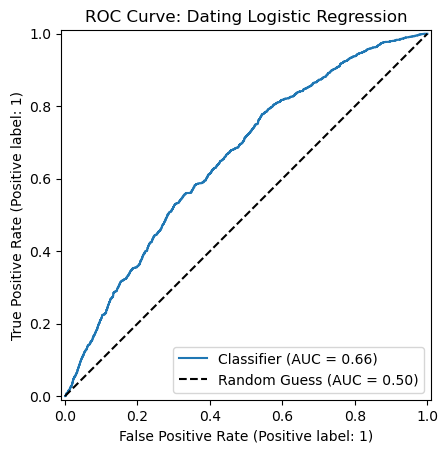

In [59]:
#----- get prob
probs = result.predict(X)  # fitted probabilities

#----- compute AUC
auc = roc_auc_score(y, probs)
print(f"AUC: {auc:.3f}")

#-----draw the graph
RocCurveDisplay.from_predictions(y, probs)
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess (AUC = 0.50)')

#-----add title
plt.title("ROC Curve: Dating Logistic Regression")
plt.legend()
plt.show()


### Determining Optimal Model Threshold

In [60]:
#Define the thresholds 
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve, auc

thresholds = np.arange(0.0, 1.1, 0.1)

metrics_list = []

pred_prob = result.predict(X)
y_true = y.values.ravel()
auc_value = roc_auc_score(y_true, pred_prob)

for threshold in thresholds:
    # Convert probabilities to classes based on the current threshold
    pred_class = (pred_prob >= threshold).astype(int)
    
    # Handle the case where the predicted class is all 0s or all 1s (which can happen at extreme thresholds)
    # This prevents warnings or errors in precision/recall calculation
    try:
        accuracy = accuracy_score(y_true, pred_class)
        precision = precision_score(y_true, pred_class, zero_division=0)
        recall = recall_score(y_true, pred_class, zero_division=0)
        f1 = f1_score(y_true, pred_class)
    except ValueError:
        # If the prediction array is empty, set metrics to NaN
        accuracy = np.nan
        precision = np.nan
        recall = np.nan
        f1 = np.nan
    
    # Store results
    metrics_list.append({
        'Threshold': f"{threshold:.1f}",
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1': f1
    })
    
# Precision-Recall AUC
precision_curve, recall_curve, _ = precision_recall_curve(y_true, pred_prob)
pr_auc = auc(recall_curve, precision_curve)

# Convert the list of dictionaries into a DataFrame
performance_df = pd.DataFrame(metrics_list)

# Sort the table by decreasing Accuracy

final_table = performance_df.sort_values(by='Accuracy', ascending=False).reset_index(drop=True)

print("\n--- Performance Metrics by Classification Threshold (Sorted by Accuracy) ---")
print(final_table)

# Original output for a single threshold (0.5)
pred_class_05 = (pred_prob >= 0.5).astype(int)
print("\nOriginal Metrics (threshold=0.5):")
acc_05  = (pred_class_05.values.ravel() == y_true).mean()
print(f"Accuracy: {acc_05:.3f} | ROC-AUC: {auc_value:.3f} | PR-AUC: {pr_auc:.3f}")


--- Performance Metrics by Classification Threshold (Sorted by Accuracy) ---
   Threshold  Accuracy  Precision    Recall        F1
0        0.6  0.902610   1.000000  0.000576  0.001151
1        0.7  0.902610   1.000000  0.000576  0.001151
2        0.5  0.902554   0.500000  0.000576  0.001151
3        0.8  0.902554   0.000000  0.000000  0.000000
4        0.9  0.902554   0.000000  0.000000  0.000000
5        1.0  0.902554   0.000000  0.000000  0.000000
6        0.4  0.902498   0.333333  0.000576  0.001150
7        0.3  0.901151   0.068966  0.001152  0.002266
8        0.2  0.887061   0.171429  0.041475  0.066790
9        0.1  0.581869   0.140103  0.640553  0.229918
10       0.0  0.097446   0.097446  1.000000  0.177587

Original Metrics (threshold=0.5):
Accuracy: 0.903 | ROC-AUC: 0.656 | PR-AUC: 0.153


### Modeling Part 2

The first model could be improved, it has a high accuracy and fair ROC-AUC. However the recall, f1, and precision recall AUC score are very low. This is due to the imbalanced nature of the data, with 7% of rows being acquired the model could predict not acquired for every data point and still achieve an accuracy of 93%. The model is unable to accurately identify acquired start-ups. Model 2 aims to improve this through adjusting some model features, adding new features, resampling the data, and adding weights to penalize acquired startups that are predicted as unacquired.

In [61]:
pd.set_option('display.max_columns', None)
investments_with_funding_types.head()

,state_code,funding_total_usd,founded_year,status,market,first_funding_year,last_funding_year,acquired,seed,venture,equity_crowdfunding,undisclosed,convertible_note,debt_financing,angel,grant,private_equity,post_ipo_equity,post_ipo_debt,secondary_market,product_crowdfunding,round_A,round_B,round_C,round_D,round_E,round_F,round_G,round_H
0,High_Regulation,1750000.0,2012.0,acquired,Media & Entertainment,2012.0,2012.0,1,1750000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Business_Friendly,60000.0,2014.0,operating,Industrial & Energy,2014.0,2014.0,0,0.0,0.0,60000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16,High_Regulation,2050000.0,2001.0,operating,Consumer & Retail,2009.0,2011.0,0,0.0,0.0,0.0,0.0,0.0,2050000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17,Business_Friendly,40000.0,2008.0,operating,Technology & Software,2011.0,2011.0,0,40000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20,High_Regulation,2535000.0,2010.0,acquired,Media & Entertainment,2010.0,2011.0,1,15000.0,2520000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2520000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [62]:
#change first funding year to years before first funding
investments_with_funding_types['years_before_first_funding']=investments_with_funding_types['first_funding_year']-investments_with_funding_types['founded_year']

#change last funding year to funding duration
investments_with_funding_types['funding_duration']=investments_with_funding_types['last_funding_year']-investments_with_funding_types['first_funding_year']

#create totals of different funding strategies

equity_financing=['seed', 'angel', 'venture', 'equity_crowdfunding',
 'private_equity', 'round_A', 'round_B', 'round_C',
 'round_D', 'round_E', 'round_F', 'round_G', 'round_H',
 'post_ipo_equity', 'secondary_market']

debt_financing=['debt_financing', 'convertible_note', 'post_ipo_debt']

public_financing=['grant', 'product_crowdfunding', 'undisclosed']


investments_with_funding_types['Equity-driven']=investments_with_funding_types[equity_financing].sum(axis=1)

investments_with_funding_types['Debt-driven']=investments_with_funding_types[debt_financing].sum(axis=1)

investments_with_funding_types['Public-driven']=investments_with_funding_types[public_financing].sum(axis=1)

#drop columns
investments_with_funding_totals=investments_with_funding_types.drop(columns=equity_financing+debt_financing+public_financing, axis=1)

investments_with_funding_totals.head()


,state_code,funding_total_usd,founded_year,status,market,first_funding_year,last_funding_year,acquired,years_before_first_funding,funding_duration,Equity-driven,Debt-driven,Public-driven
0,High_Regulation,1750000.0,2012.0,acquired,Media & Entertainment,2012.0,2012.0,1,0.0,0.0,1750000.0,0.0,0.0
4,Business_Friendly,60000.0,2014.0,operating,Industrial & Energy,2014.0,2014.0,0,0.0,0.0,60000.0,0.0,0.0
16,High_Regulation,2050000.0,2001.0,operating,Consumer & Retail,2009.0,2011.0,0,8.0,2.0,0.0,2050000.0,0.0
17,Business_Friendly,40000.0,2008.0,operating,Technology & Software,2011.0,2011.0,0,3.0,0.0,40000.0,0.0,0.0
20,High_Regulation,2535000.0,2010.0,acquired,Media & Entertainment,2010.0,2011.0,1,0.0,1.0,5055000.0,0.0,0.0


In [63]:
#find the funding strategy that is the highest for each start up

investments_with_funding_totals['primary_funding_type']=investments_with_funding_totals[['Equity-driven','Debt-driven','Public-driven']].idxmax(axis=1)

#drop columns

model2_cleaned=investments_with_funding_totals.drop(['Equity-driven','Debt-driven','Public-driven', 'first_funding_year','last_funding_year', 'status'], axis=1)

model2_cleaned.head()

,state_code,funding_total_usd,founded_year,market,acquired,years_before_first_funding,funding_duration,primary_funding_type
0,High_Regulation,1750000.0,2012.0,Media & Entertainment,1,0.0,0.0,Equity-driven
4,Business_Friendly,60000.0,2014.0,Industrial & Energy,0,0.0,0.0,Equity-driven
16,High_Regulation,2050000.0,2001.0,Consumer & Retail,0,8.0,2.0,Debt-driven
17,Business_Friendly,40000.0,2008.0,Technology & Software,0,3.0,0.0,Equity-driven
20,High_Regulation,2535000.0,2010.0,Media & Entertainment,1,0.0,1.0,Equity-driven


In [64]:
import imblearn.over_sampling as OS
import imblearn.under_sampling as US
from imblearn.over_sampling import SMOTENC

#increase acquired rows from 7%->30% of total
smote = OS.SMOTE(sampling_strategy=0.3, random_state=42)

# Separate X and y dataframe
X = model2_cleaned.drop(columns='acquired')
y = model2_cleaned['acquired']

#encode categorical variables
categorical_cols = ['state_code', 'market', 'primary_funding_type']
X_encoded = X.copy()

for col in categorical_cols:
    X_encoded[col] = X_encoded[col].astype('category').cat.codes

cat_indices = [X_encoded.columns.get_loc(col) for col in categorical_cols]

#initialize SMOTE
smote_nc = SMOTENC(categorical_features=cat_indices, sampling_strategy=0.3, random_state=42)

# Apply resampling
X_resampled, y_resampled = smote_nc.fit_resample(X_encoded, y)

# Convert back to DataFrame
X_resampled_df = pd.DataFrame(X_resampled, columns=X_encoded.columns)
y_resampled_df = pd.Series(y_resampled, name='acquired')

# Combine into a single DataFrame
model2_balanced = pd.concat([y_resampled_df, X_resampled_df], axis=1)

#convert categorical data back to text
for col in categorical_cols:
    cat_map = dict(enumerate(X[col].astype('category').cat.categories))
    model2_balanced[col] = model2_balanced[col].map(cat_map)

#check 
balanced=np.bincount(model2_balanced['acquired'])
original=np.bincount(model2_cleaned['acquired'])

print(f'Total unacquired vs acquired startups before balancing {original[0]}:{original[1]}, acquired={(original[1]/(original[1]+original[0])*100):.2f}%')
print(f'Total unacquired vs acquired startups after balancing {balanced[0]}:{balanced[1]}, acquired={(balanced[1]/(balanced[1]+balanced[0])*100):.2f}%')

model2_balanced.head()

Total unacquired vs acquired startups before balancing 16080:1736, acquired=9.74%
Total unacquired vs acquired startups after balancing 16080:4824, acquired=23.08%


,acquired,state_code,funding_total_usd,founded_year,market,years_before_first_funding,funding_duration,primary_funding_type
0,1,High_Regulation,1750000.0,2012.0,Media & Entertainment,0.0,0.0,Equity-driven
1,0,Business_Friendly,60000.0,2014.0,Industrial & Energy,0.0,0.0,Equity-driven
2,0,High_Regulation,2050000.0,2001.0,Consumer & Retail,8.0,2.0,Debt-driven
3,0,Business_Friendly,40000.0,2008.0,Technology & Software,3.0,0.0,Equity-driven
4,1,High_Regulation,2535000.0,2010.0,Media & Entertainment,0.0,1.0,Equity-driven


In [65]:
# OTHMANE'S PART FROM THIS POINT ONWARDS

In [66]:
# DATA PREPARATION FOR ASSUMPTION CHECKS AND MODELING
# One-hot encode categorical variables and transform founded_year to years_since_founding
# Using ONLY original data (model2_cleaned) - NOT SMOTE resampled data

import numpy as np
import pandas as pd

# Separate features and target from original data
X_original = model2_cleaned.drop(columns='acquired')
y_original = model2_cleaned['acquired']

# Transform founded_year to years_since_founding (company age as of 2014)
DATASET_YEAR = 2014
X_original['years_since_founding'] = DATASET_YEAR - X_original['founded_year']
X_original = X_original.drop(columns=['founded_year'])

# Identify categorical and numerical variables
categorical_cols = ['state_code', 'market', 'primary_funding_type']
numerical_cols = [col for col in X_original.columns if col not in categorical_cols]

# One-hot encode categorical variables
X_encoded_onehot = pd.get_dummies(
    X_original,
    columns=categorical_cols,
    prefix=categorical_cols,
    drop_first=False,
    dtype=float
)

# Create final prepared dataset
X_prepared = X_encoded_onehot.copy()
y_prepared = y_original.copy()

# Display summary
print(f"Dataset prepared: {X_prepared.shape[0]} observations × {X_prepared.shape[1]} features")
print(f"\nFeature breakdown:")
print(f"  Categorical (one-hot encoded): {categorical_cols}")
print(f"  Numerical: {numerical_cols}")
print(f"\nTarget distribution:")
for val, count in y_prepared.value_counts().sort_index().items():
    label = "Not Acquired" if val == 0 else "Acquired"
    print(f"  {label}: {count} ({count/len(y_prepared)*100:.2f}%)")
print(f"\nSummary statistics for numerical features:")
print(X_prepared[numerical_cols].describe())

Dataset prepared: 17816 observations × 21 features

Feature breakdown:
  Categorical (one-hot encoded): ['state_code', 'market', 'primary_funding_type']
  Numerical: ['funding_total_usd', 'years_before_first_funding', 'funding_duration', 'years_since_founding']

Target distribution:
  Not Acquired: 16080 (90.26%)
  Acquired: 1736 (9.74%)

Summary statistics for numerical features:
       funding_total_usd  years_before_first_funding  funding_duration  \
count       1.781600e+04                17816.000000      17816.000000   
mean        1.634155e+07                    2.084587          1.327851   
std         7.559254e+07                    2.635149          1.960715   
min         3.000000e+01                  -10.000000          0.000000   
25%         5.000000e+05                    0.000000          0.000000   
50%         2.450000e+06                    1.000000          0.000000   
75%         1.150000e+07                    3.000000          2.000000   
max         5.700000e+09

## Data Preparation Summary

**What was done:**
- **One-hot encoding**: Converted categorical variables (`state_code`, `market`, `primary_funding_type`) into binary dummy variables
- **Feature transformation**: Transformed `founded_year` to `years_since_founding` (company age as of 2014) for better interpretability
- **Dataset**: Using **ORIGINAL data** (model2_cleaned) - NOT SMOTE-resampled data

**Why this matters:**
- Logistic regression requires numerical inputs - categorical variables must be encoded
- One-hot encoding creates separate binary features for each category (e.g., state_code_CA, state_code_NY)
- Company age is more meaningful than raw founding year for prediction
- Using original data ensures assumption checks reflect true data properties (SMOTE introduces synthetic samples)

**Output variables:**
- `X_prepared`: Feature matrix ready for modeling
- `y_prepared`: Target variable (acquired: 0 or 1)

ASSUMPTION 1: Correct Specification & VIF Check

Using X_prepared ((17816, 21)) and y_prepared (17816 obs)
Note: Using ORIGINAL data (not SMOTE)

Features: 21 total
  Categorical: 17
  Continuous: 4

Calculating VIF (Variance Inflation Factor)...

VIF Values:
                            Feature      VIF
                   market_Education      inf
         market_Finance & Insurance      inf
 primary_funding_type_Equity-driven      inf
   primary_funding_type_Debt-driven      inf
       market_Technology & Software      inf
market_Real Estate & Local Services      inf
                       market_Other      inf
       market_Media & Entertainment      inf
         market_Industrial & Energy      inf
           market_Health & Wellness      inf
 primary_funding_type_Public-driven      inf
           market_Consumer & Retail      inf
           market_Business Services      inf
                   state_code_Other      inf
                state_code_Moderate      inf
         state_code_

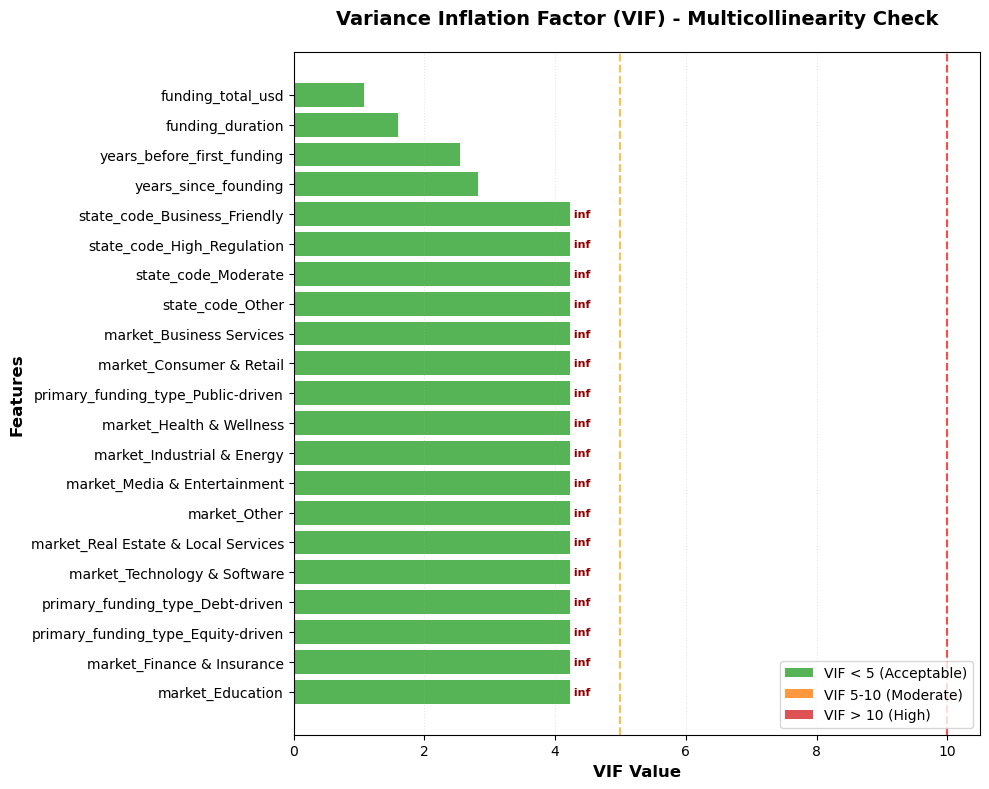


VIF Assessment:
  High (>10): 17 features
  Moderate (5-10): 0 features
  Acceptable (<5): 4 features

  WARNING - High multicollinearity detected in:
    market_Education: inf
    market_Finance & Insurance: inf
    primary_funding_type_Equity-driven: inf
    primary_funding_type_Debt-driven: inf
    market_Technology & Software: inf
    market_Real Estate & Local Services: inf
    market_Other: inf
    market_Media & Entertainment: inf
    market_Industrial & Energy: inf
    market_Health & Wellness: inf


In [67]:
# ASSUMPTION 1: CORRECT SPECIFICATION & MULTICOLLINEARITY CHECK (VIF)

import numpy as np
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

print("ASSUMPTION 1: Correct Specification & VIF Check")
print(f"\nUsing X_prepared ({X_prepared.shape}) and y_prepared ({len(y_prepared)} obs)")
print("Note: Using ORIGINAL data (not SMOTE)")

# Display feature types
categorical_encoded_cols = ['state_code', 'market', 'primary_funding_type']
continuous_cols = [col for col in X_prepared.columns
                   if not any(col.startswith(prefix) for prefix in categorical_encoded_cols)]

print(f"\nFeatures: {X_prepared.shape[1]} total")
print(f"  Categorical: {len([c for c in X_prepared.columns if any(c.startswith(p) for p in categorical_encoded_cols)])}")
print(f"  Continuous: {len(continuous_cols)}")

# VIF Calculation
print("\nCalculating VIF (Variance Inflation Factor)...")
vif_data = pd.DataFrame()
vif_data["Feature"] = X_prepared.columns
vif_data["VIF"] = [variance_inflation_factor(X_prepared.values, i)
                   for i in range(X_prepared.shape[1])]
vif_data = vif_data.sort_values('VIF', ascending=False).reset_index(drop=True)

print("\nVIF Values:")
print(vif_data.to_string(index=False))

# VIF Visualization
vif_plot_data = vif_data.copy()
vif_plot_data['VIF_display'] = vif_plot_data['VIF'].replace(
    [np.inf, -np.inf],
    vif_plot_data[vif_plot_data['VIF'] != np.inf]['VIF'].max() * 1.5
)

fig, ax = plt.subplots(figsize=(10, max(8, len(vif_plot_data) * 0.3)))

colors = ['#d62728' if v > 10 else '#ff7f0e' if v >= 5 else '#2ca02c'
          for v in vif_plot_data['VIF_display']]

ax.barh(vif_plot_data['Feature'], vif_plot_data['VIF_display'], color=colors, alpha=0.8)
ax.axvline(x=5, color='orange', linestyle='--', linewidth=1.5, alpha=0.7)
ax.axvline(x=10, color='red', linestyle='--', linewidth=1.5, alpha=0.7)
ax.set_xlabel('VIF Value', fontsize=12, fontweight='bold')
ax.set_ylabel('Features', fontsize=12, fontweight='bold')
ax.set_title('Variance Inflation Factor (VIF) - Multicollinearity Check',
             fontsize=14, fontweight='bold', pad=20)
ax.grid(axis='x', alpha=0.3, linestyle=':')

legend_elements = [
    Patch(facecolor='#2ca02c', alpha=0.8, label='VIF < 5 (Acceptable)'),
    Patch(facecolor='#ff7f0e', alpha=0.8, label='VIF 5-10 (Moderate)'),
    Patch(facecolor='#d62728', alpha=0.8, label='VIF > 10 (High)')
]
ax.legend(handles=legend_elements, loc='lower right', fontsize=10)

for i, (idx, row) in enumerate(vif_plot_data.iterrows()):
    if np.isinf(row['VIF']):
        ax.text(row['VIF_display'], i, ' inf', va='center', fontsize=8,
                fontweight='bold', color='darkred')

plt.tight_layout()
plt.show()

# VIF Assessment Summary
high_vif = vif_data[vif_data['VIF'] > 10]
moderate_vif = vif_data[(vif_data['VIF'] >= 5) & (vif_data['VIF'] <= 10)]
acceptable_vif = vif_data[vif_data['VIF'] < 5]

print(f"\nVIF Assessment:")
print(f"  High (>10): {len(high_vif)} features")
print(f"  Moderate (5-10): {len(moderate_vif)} features")
print(f"  Acceptable (<5): {len(acceptable_vif)} features")

if len(high_vif) > 0:
    print("\n  WARNING - High multicollinearity detected in:")
    for _, row in high_vif.head(10).iterrows():
        print(f"    {row['Feature']}: {row['VIF']:.2f}")

## Assumption 1: Correct Specification & Multicollinearity (VIF)

**What is VIF (Variance Inflation Factor)?**
VIF measures how much the variance of a regression coefficient is inflated due to correlation with other predictors. It quantifies multicollinearity.

**VIF Interpretation Guidelines:**
- **VIF < 5**: Acceptable - low multicollinearity, no action needed
- **VIF 5-10**: Moderate multicollinearity - use caution, monitor coefficients
- **VIF > 10**: High multicollinearity - problematic, consider removing or combining features

**Why multicollinearity matters:**
- Inflates standard errors, making coefficients unstable
- Makes it hard to determine individual predictor effects
- Doesn't affect predictions, but affects interpretation of coefficients

**What to do if VIF is high:**
1. Remove one of the correlated features
2. Combine correlated features (e.g., create composite scores)
3. Use regularization (L1/L2 penalties)
4. Accept it if prediction (not interpretation) is the goal

**In this analysis:**
- One-hot encoded categorical variables naturally have high VIF (by design)
- Focus on VIF for continuous variables when assessing multicollinearity issues

In [68]:
# ASSUMPTION 2: INDEPENDENCE OF OBSERVATIONS

print("ASSUMPTION 2: Independence of Observations")
print(f"\nUsing X_prepared ({X_prepared.shape}), y_prepared ({len(y_prepared)} obs)")
print("Note: Using ORIGINAL data (not SMOTE)")

# Check for duplicate observations
total_obs = len(X_prepared)
duplicate_rows_X = X_prepared.duplicated().sum()
duplicate_rows_full = model2_cleaned.duplicated().sum()

print(f"\nDuplicate Check:")
print(f"  Total observations: {total_obs}")
print(f"  Duplicates in X_prepared: {duplicate_rows_X}")
print(f"  Duplicates in model2_cleaned: {duplicate_rows_full}")

if duplicate_rows_X == 0 and duplicate_rows_full == 0:
    print("  ✓ No duplicates - each row is unique")
else:
    print(f"  Note: {duplicate_rows_full} rows with identical features (different startups)")
    print("  This is acceptable - represents independent entities with similar characteristics")

# Distribution across categorical groupings
print("\nDistribution Analysis:")

state_counts = model2_cleaned['state_code'].value_counts()
print(f"\n  States: {model2_cleaned['state_code'].nunique()} unique")
print(f"    Mean per state: {state_counts.mean():.2f}")
print(f"    Most common: {state_counts.index[0]} ({state_counts.values[0]} startups)")

market_counts = model2_cleaned['market'].value_counts()
print(f"\n  Markets: {model2_cleaned['market'].nunique()} unique")
print(f"    Mean per market: {market_counts.mean():.2f}")
print(f"    Most common: {market_counts.index[0]} ({market_counts.values[0]} startups)")

funding_counts = model2_cleaned['primary_funding_type'].value_counts()
print(f"\n  Funding Types: {model2_cleaned['primary_funding_type'].nunique()} unique")
for funding_type, count in funding_counts.items():
    print(f"    {funding_type}: {count} ({count/len(model2_cleaned)*100:.2f}%)")

# Temporal characteristics
print("\nTemporal Characteristics:")
print(f"  Company age range: {X_prepared['years_since_founding'].min():.0f} - {X_prepared['years_since_founding'].max():.0f} years")
print(f"  Funding duration range: {model2_cleaned['funding_duration'].min():.0f} - {model2_cleaned['funding_duration'].max():.0f} years")
print("  ✓ Cross-sectional data (not time series)")

# Acquisition rates by groupings
print("\nAcquisition Rates by State (Top 10):")
top_states = state_counts.head(10).index
for state in top_states:
    state_data = model2_cleaned[model2_cleaned['state_code'] == state]
    acq_rate = state_data['acquired'].mean() * 100
    print(f"  {state}: {acq_rate:.1f}% (n={len(state_data)})")

print("\nAcquisition Rates by Market (Top 10):")
top_markets = market_counts.head(10).index
for market in top_markets:
    market_data = model2_cleaned[model2_cleaned['market'] == market]
    acq_rate = market_data['acquired'].mean() * 100
    print(f"  {market}: {acq_rate:.1f}% (n={len(market_data)})")

print("\n✓ Independence assumption satisfied")
print("  Each observation is a unique, independent startup entity")
print("  No hierarchical nesting or time-series dependencies")

ASSUMPTION 2: Independence of Observations

Using X_prepared ((17816, 21)), y_prepared (17816 obs)
Note: Using ORIGINAL data (not SMOTE)

Duplicate Check:
  Total observations: 17816
  Duplicates in X_prepared: 917
  Duplicates in model2_cleaned: 842
  Note: 842 rows with identical features (different startups)
  This is acceptable - represents independent entities with similar characteristics

Distribution Analysis:

  States: 4 unique
    Mean per state: 4454.00
    Most common: High_Regulation (10297 startups)

  Markets: 10 unique
    Mean per market: 1781.60
    Most common: Technology & Software (7219 startups)

  Funding Types: 3 unique
    Equity-driven: 16389 (91.99%)
    Debt-driven: 1105 (6.20%)
    Public-driven: 322 (1.81%)

Temporal Characteristics:
  Company age range: 0 - 14 years
  Funding duration range: 0 - 15 years
  ✓ Cross-sectional data (not time series)

Acquisition Rates by State (Top 10):
  High_Regulation: 11.4% (n=10297)
  Moderate: 7.3% (n=3811)
  Business_

## Assumption 2: Independence of Observations

**What is the independence assumption?**
Each observation (startup) should be independent of others. Violations occur when:
- Observations are clustered (e.g., multiple measurements from same entity)
- Data has hierarchical structure (e.g., employees nested within companies)
- Time-series dependencies exist (e.g., repeated measurements over time)

**Why it matters:**
- Violating independence leads to biased standard errors
- P-values and confidence intervals become unreliable
- Can overestimate model significance

**In this dataset:**
- ✓ Each row represents a unique startup entity
- ✓ Cross-sectional data (one snapshot per startup, not tracked over time)
- ✓ No hierarchical nesting (startups are not nested within parent companies)
- ✓ Some clustering by state/market is expected but acceptable (startups are still independent entities)

**Notes:**
- Duplicate rows with identical features represent different startups with similar characteristics - still independent
- Geographic/market clustering is natural in business data and doesn't violate independence
- Independence would be violated if we had repeated measurements of same startups over time

ASSUMPTION 3: Linearity of Logit

Using X_prepared ((17816, 21)), y_prepared (17816 obs)
Note: Using ORIGINAL data (not SMOTE)

Continuous variables to test: 4
  1. funding_total_usd
  2. years_before_first_funding
  3. funding_duration
  4. years_since_founding

Box-Tidwell Test Results:
                  Variable          Coef     Abs_Coef Result
      years_since_founding -7.095874e-02 7.095874e-02   FAIL
          funding_duration -5.955651e-02 5.955651e-02   FAIL
years_before_first_funding -5.646215e-02 5.646215e-02   FAIL
         funding_total_usd  1.730088e-08 1.730088e-08   PASS

Summary: PASS=1, CAUTION=0, FAIL=3

Generating Empirical Logit Plots...


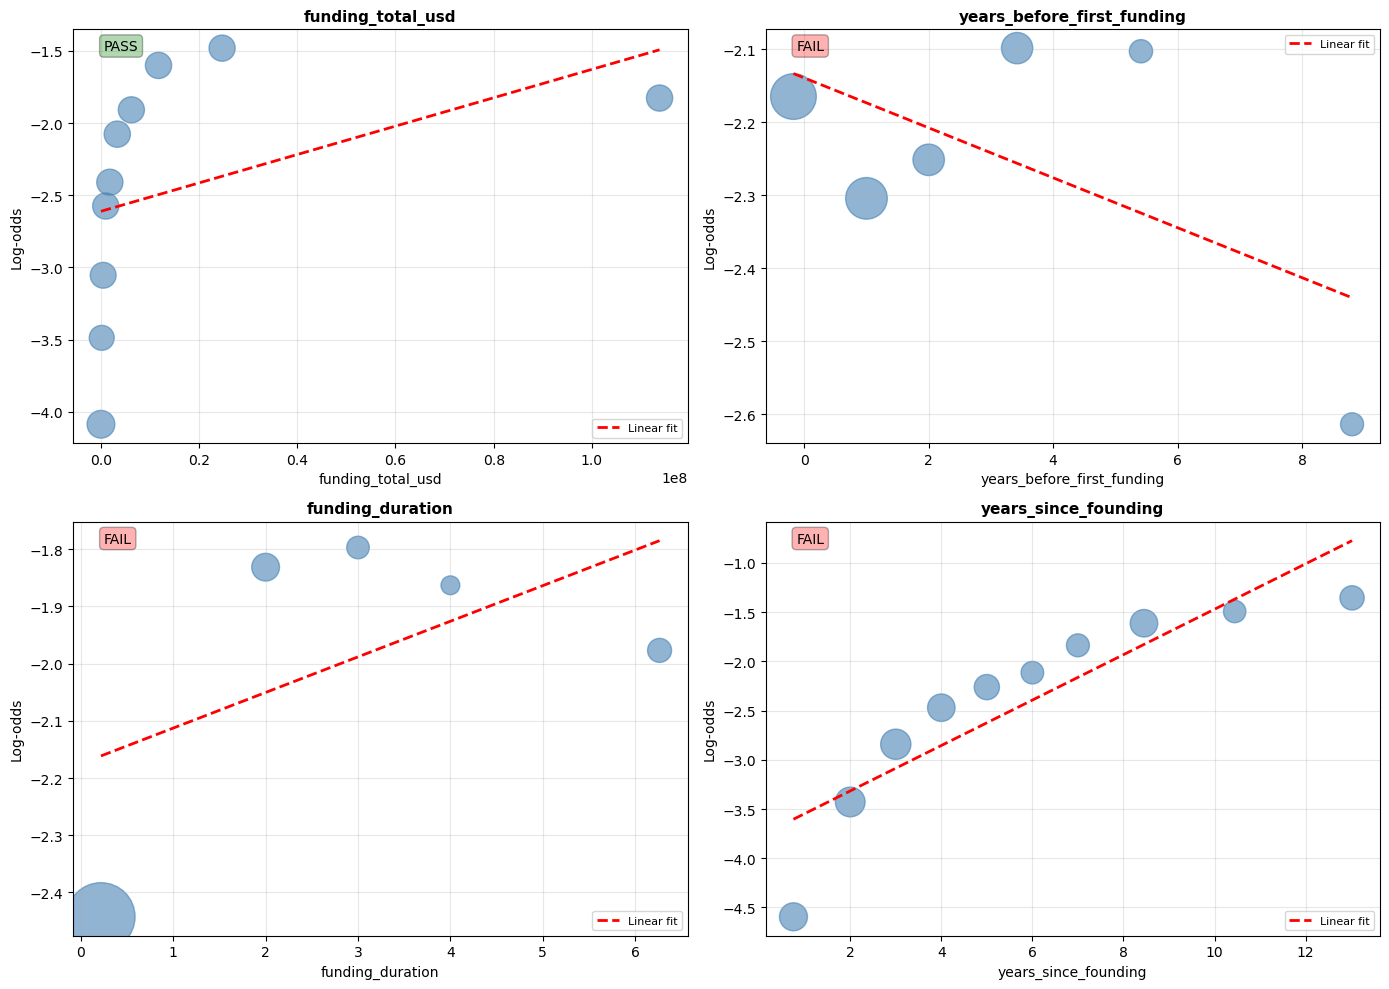


Handling Non-Linear Variables:
Converting 3 failed variable(s) to categorical bins:
  years_since_founding → company_age_category (4 bins)
  funding_duration → funding_duration_category (binned)
  years_before_first_funding → funding_speed_category (4 bins)

✓ One-hot encoded 3 new categorical variables

Final Feature Set: 29 features
  Continuous (linear): 1
  Categorical (binned): 28

✓ Linearity assumption satisfied for remaining continuous variables


In [69]:
# ASSUMPTION 3: LINEARITY OF LOGIT

import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

print("ASSUMPTION 3: Linearity of Logit")
print(f"\nUsing X_prepared ({X_prepared.shape}), y_prepared ({len(y_prepared)} obs)")
print("Note: Using ORIGINAL data (not SMOTE)")

# Identify continuous variables
categorical_prefixes = ['state_code_', 'market_', 'primary_funding_type_',
                       'company_age_category_', 'funding_speed_category_']
continuous_vars = [col for col in X_prepared.columns
                  if not any(col.startswith(prefix) for prefix in categorical_prefixes)]

print(f"\nContinuous variables to test: {len(continuous_vars)}")
for idx, var in enumerate(continuous_vars, 1):
    print(f"  {idx}. {var}")

# Box-Tidwell Test
print("\nBox-Tidwell Test Results:")
linearity_results = []

for var in continuous_vars:
    min_val = X_prepared[var].min()

    # Prepare interaction term
    X_temp = X_prepared.copy()
    if min_val <= 0:
        constant = abs(min_val) + 1
        X_temp[f'{var}_shifted'] = X_prepared[var] + constant
        X_temp[f'{var}_interaction'] = X_temp[f'{var}_shifted'] * np.log(X_temp[f'{var}_shifted'])
    else:
        X_temp[f'{var}_interaction'] = X_prepared[var] * np.log(X_prepared[var])

    # Fit model and get interaction coefficient
    try:
        model = LogisticRegression(max_iter=1000, random_state=42, solver='lbfgs')
        model.fit(X_temp, y_prepared)
        interaction_coef = model.coef_[0][-1]

        # Determine pass/fail
        if abs(interaction_coef) < 0.01:
            result = "PASS"
        elif abs(interaction_coef) < 0.05:
            result = "CAUTION"
        else:
            result = "FAIL"

        linearity_results.append({
            'Variable': var,
            'Coef': interaction_coef,
            'Abs_Coef': abs(interaction_coef),
            'Result': result
        })
    except Exception as e:
        linearity_results.append({
            'Variable': var,
            'Coef': np.nan,
            'Abs_Coef': np.nan,
            'Result': 'ERROR'
        })

results_df = pd.DataFrame(linearity_results).sort_values('Abs_Coef', ascending=False)
print(results_df.to_string(index=False))

n_pass = len(results_df[results_df['Result'] == 'PASS'])
n_caution = len(results_df[results_df['Result'] == 'CAUTION'])
n_fail = len(results_df[results_df['Result'] == 'FAIL'])
print(f"\nSummary: PASS={n_pass}, CAUTION={n_caution}, FAIL={n_fail}")

# Empirical Logit Plots
print("\nGenerating Empirical Logit Plots...")
n_vars = len(continuous_vars)
n_cols = 2
n_rows = (n_vars + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 5 * n_rows))
if n_vars == 1:
    axes = [axes]
else:
    axes = axes.flatten()

for idx, var in enumerate(continuous_vars):
    ax = axes[idx]

    # Bin variable and calculate empirical logit
    try:
        X_prepared[f'{var}_binned'], _ = pd.qcut(X_prepared[var], q=10, duplicates='drop', retbins=True)
    except:
        X_prepared[f'{var}_binned'], _ = pd.cut(X_prepared[var], bins=10, duplicates='drop', retbins=True)

    bin_stats = X_prepared.groupby(f'{var}_binned', observed=True).agg({var: 'mean'})
    bin_outcomes = pd.DataFrame({'bin': X_prepared[f'{var}_binned'], 'outcome': y_prepared})
    bin_outcomes = bin_outcomes.groupby('bin', observed=True)['outcome'].agg(['sum', 'count'])

    epsilon = 0.01
    bin_outcomes['prop'] = bin_outcomes['sum'] / bin_outcomes['count']
    bin_outcomes['prop_adj'] = bin_outcomes['prop'].clip(epsilon, 1 - epsilon)
    bin_outcomes['logit'] = np.log(bin_outcomes['prop_adj'] / (1 - bin_outcomes['prop_adj']))

    bin_stats = bin_stats.join(bin_outcomes[['logit', 'count']])

    x_vals = bin_stats[var].values
    y_vals = bin_stats['logit'].values

    # Plot
    ax.scatter(x_vals, y_vals, s=bin_stats['count'].values/5, alpha=0.6, color='steelblue')

    if len(x_vals) > 1:
        z = np.polyfit(x_vals, y_vals, 1)
        p = np.poly1d(z)
        ax.plot(x_vals, p(x_vals), "r--", linewidth=2, label='Linear fit')

    ax.set_xlabel(var, fontsize=10)
    ax.set_ylabel('Log-odds', fontsize=10)
    ax.set_title(f'{var}', fontsize=11, fontweight='bold')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

    # Add result label
    result = results_df[results_df['Variable'] == var]['Result'].values[0]
    color = 'green' if result == 'PASS' else ('orange' if result == 'CAUTION' else 'red')
    ax.text(0.05, 0.95, f'{result}', transform=ax.transAxes, fontsize=10,
           bbox=dict(boxstyle='round', facecolor=color, alpha=0.3))

    X_prepared.drop(columns=[f'{var}_binned'], inplace=True)

for idx in range(len(continuous_vars), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

# Handle non-linear variables
print("\nHandling Non-Linear Variables:")
failed_vars = results_df[results_df['Result'] == 'FAIL']['Variable'].tolist()

if len(failed_vars) == 0:
    print("✓ All variables passed - no action needed")
else:
    print(f"Converting {len(failed_vars)} failed variable(s) to categorical bins:")

    for var in failed_vars:
        if var == 'years_since_founding':
            X_prepared['company_age_category'] = pd.cut(
                X_prepared[var],
                bins=[-0.1, 2, 5, 10, 100],
                labels=['Very_Young_0-2yrs', 'Young_3-5yrs', 'Mature_6-10yrs', 'Established_10plus_yrs']
            )
            print(f"  {var} → company_age_category (4 bins)")
            X_prepared.drop(columns=[var], inplace=True)

        elif var == 'years_before_first_funding':
            X_prepared['funding_speed_category'] = pd.cut(
                X_prepared[var],
                bins=[-0.1, 0.5, 2, 5, 100],
                labels=['Immediate_0yrs', 'Fast_1-2yrs', 'Moderate_3-5yrs', 'Slow_5plus_yrs']
            )
            print(f"  {var} → funding_speed_category (4 bins)")
            X_prepared.drop(columns=[var], inplace=True)

        elif var == 'funding_total_usd':
            X_prepared['funding_category'] = pd.cut(
                X_prepared[var],
                bins=[-1, 100000, 1000000, 5000000, 10000000, np.inf],
                labels=['Seed_0-100K', 'Small_100K-1M', 'Medium_1M-5M', 'Large_5M-10M', 'Huge_10M_plus']
            )
            print(f"  {var} → funding_category (5 bins)")
            X_prepared.drop(columns=[var], inplace=True)
        else:
            X_prepared[f'{var}_category'], _ = pd.qcut(
                X_prepared[var], q=5, duplicates='drop', retbins=True
            )
            print(f"  {var} → {var}_category (binned)")
            X_prepared.drop(columns=[var], inplace=True)

    # One-hot encode new categorical variables
    new_cat_cols = [col for col in X_prepared.columns if col.endswith('_category')]
    if len(new_cat_cols) > 0:
        X_prepared = pd.get_dummies(X_prepared, columns=new_cat_cols,
                                    prefix=new_cat_cols, drop_first=False, dtype=float)
        print(f"\n✓ One-hot encoded {len(new_cat_cols)} new categorical variables")

# Final summary
all_categorical_prefixes = ['state_code_', 'market_', 'primary_funding_type_',
                            'company_age_category_', 'funding_speed_category_',
                            'funding_category_', 'funding_duration_category_']
remaining_continuous = [col for col in X_prepared.columns
                       if not any(col.startswith(prefix) for prefix in all_categorical_prefixes)]

print(f"\nFinal Feature Set: {X_prepared.shape[1]} features")
print(f"  Continuous (linear): {len(remaining_continuous)}")
print(f"  Categorical (binned): {X_prepared.shape[1] - len(remaining_continuous)}")
print("\n✓ Linearity assumption satisfied for remaining continuous variables")

## Assumption 3: Linearity of Logit

**What is the linearity assumption?**
The relationship between continuous predictors and the log-odds of the outcome should be linear. This doesn't mean the predictor and outcome are linearly related, but rather that the predictor and the logit (log-odds) are linear.

**Testing method: Box-Tidwell Test**
- Creates interaction term: X × ln(X)
- Tests if interaction coefficient is significant
- **PASS** (|coef| < 0.01): Linear relationship ✓
- **CAUTION** (|coef| 0.01-0.05): Minor non-linearity, monitor
- **FAIL** (|coef| > 0.05): Non-linear relationship, action needed

**Visual verification: Empirical Logit Plots**
- Bins continuous variable into groups
- Calculates log-odds for each group
- Plots to check if relationship is linear
- Straight line pattern = linearity satisfied ✓
- Curved pattern = non-linearity present ⚠

**What to do if linearity fails:**
1. **Transform the variable** (log, square root, polynomial)
2. **Bin into categories** (convert continuous → categorical) ← Used in this analysis
3. **Use splines** (piecewise linear functions)

**In this analysis:**
- Variables that **FAIL** linearity test are converted to categorical bins
- Categorical variables don't require linearity assumption (no relationship to test)
- One-hot encoding handles categorical bins properly
- Result: Linearity assumption is satisfied for remaining continuous variables

PRELIMINARY MODEL: Baseline Performance

Dataset: 17816 observations × 29 features
  Continuous: 1, Categorical: 28

Target distribution:
  Not Acquired: 16080 (90.26%)
  Acquired: 1736 (9.74%)

Train/Test Split (80/20):
  Training: 14252 (80.0%)
  Testing: 3564 (20.0%)

Training Logistic Regression (class_weight='balanced')...
✓ Model trained

Model Selection Criteria:
  Log-Likelihood: -3899.6086
  AIC: 7853.2171
  BIC: 8057.4627
  Pseudo R²: 0.1435
  Parameters: 30

Performance Metrics:

TRAINING SET:
  Accuracy: 0.0975 (9.75%)
  ROC-AUC: 0.6707
  Confusion Matrix: TN=0, FP=12863, FN=0, TP=1389

              precision    recall  f1-score   support

Not Acquired     0.0000    0.0000    0.0000     12863
    Acquired     0.0975    1.0000    0.1776      1389

    accuracy                         0.0975     14252
   macro avg     0.0487    0.5000    0.0888     14252
weighted avg     0.0095    0.0975    0.0173     14252

TESTING SET:
  Accuracy: 0.0974 (9.74%)
  ROC-AUC: 0.6809
  Confusi

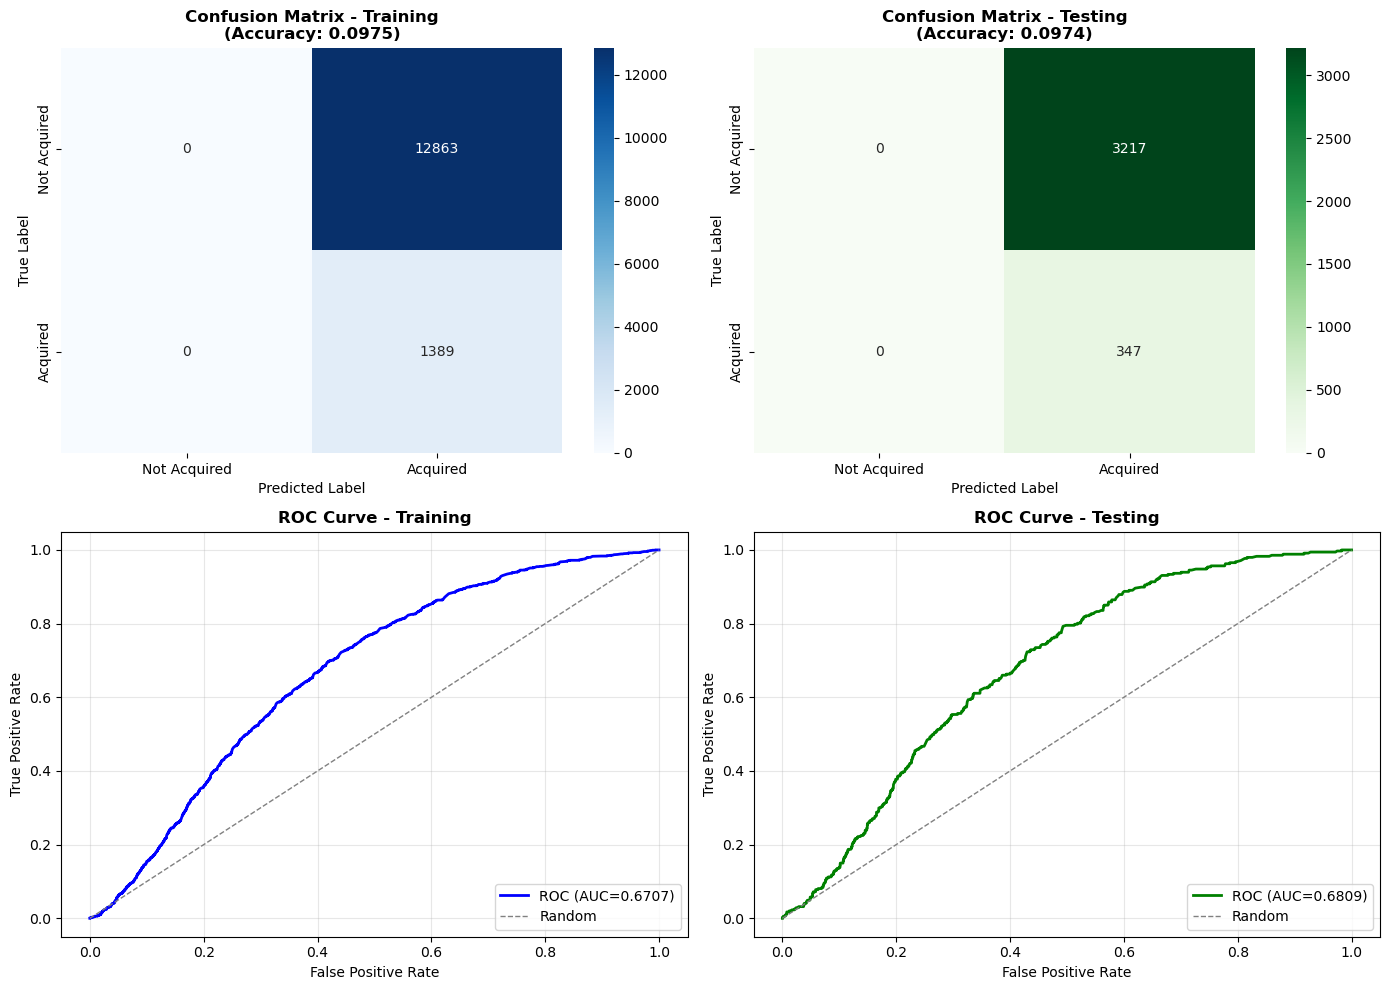


Performance at Different Thresholds (Testing Set):
 Threshold  Accuracy  Precision   Recall  F1-Score
       0.1  0.097363   0.097363 1.000000  0.177448
       0.2  0.097363   0.097363 1.000000  0.177448
       0.3  0.097363   0.097363 1.000000  0.177448
       0.4  0.097363   0.097363 1.000000  0.177448
       0.5  0.097363   0.097363 1.000000  0.177448
       0.6  0.897868   0.160000 0.011527  0.021505
       0.7  0.901235   0.222222 0.005764  0.011236
       0.8  0.901235   0.142857 0.002882  0.005650
       0.9  0.902357   0.333333 0.002882  0.005714

✓ Preliminary model complete


In [70]:
# PRELIMINARY MODEL: TRAIN/TEST SPLIT & BASELINE RESULTS

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report, confusion_matrix,
                             accuracy_score, roc_auc_score, roc_curve)
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

print("PRELIMINARY MODEL: Baseline Performance")
print(f"\nDataset: {X_prepared.shape[0]} observations × {X_prepared.shape[1]} features")

# Identify feature types
categorical_prefixes = ['state_code_', 'market_', 'primary_funding_type_',
                       'company_age_category_', 'funding_speed_category_',
                       'funding_category_', 'funding_duration_category_']
continuous_features = [col for col in X_prepared.columns
                      if not any(col.startswith(prefix) for prefix in categorical_prefixes)]
categorical_features = [col for col in X_prepared.columns
                       if any(col.startswith(prefix) for prefix in categorical_prefixes)]

print(f"  Continuous: {len(continuous_features)}, Categorical: {len(categorical_features)}")
print(f"\nTarget distribution:")
for val, count in y_prepared.value_counts().sort_index().items():
    label = "Not Acquired" if val == 0 else "Acquired"
    print(f"  {label}: {count} ({count/len(y_prepared)*100:.2f}%)")

# Train/Test Split
print("\nTrain/Test Split (80/20):")
RANDOM_STATE = 42
X_train, X_test, y_train, y_test = train_test_split(
    X_prepared, y_prepared, test_size=0.2, random_state=RANDOM_STATE, stratify=y_prepared
)
print(f"  Training: {len(X_train)} ({len(X_train)/len(X_prepared)*100:.1f}%)")
print(f"  Testing: {len(X_test)} ({len(X_test)/len(X_prepared)*100:.1f}%)")

# Train Model
print("\nTraining Logistic Regression (class_weight='balanced')...")
model_preliminary = LogisticRegression(
    max_iter=1000, random_state=RANDOM_STATE, solver='lbfgs',
    class_weight='balanced', penalty='l2', C=1.0
)
model_preliminary.fit(X_train, y_train)
print("✓ Model trained")

# Model Selection Criteria (AIC/BIC)
print("\nModel Selection Criteria:")
X_train_const = sm.add_constant(X_train)
logit_model = sm.Logit(y_train, X_train_const)
logit_result = logit_model.fit(disp=0)

print(f"  Log-Likelihood: {logit_result.llf:.4f}")
print(f"  AIC: {logit_result.aic:.4f}")
print(f"  BIC: {logit_result.bic:.4f}")
print(f"  Pseudo R²: {logit_result.prsquared:.4f}")
print(f"  Parameters: {len(logit_result.params)}")

# Predictions
y_train_pred = model_preliminary.predict(X_train)
y_train_pred_proba = model_preliminary.predict_proba(X_train)[:, 1]
y_test_pred = model_preliminary.predict(X_test)
y_test_pred_proba = model_preliminary.predict_proba(X_test)[:, 1]

# Performance Metrics
print("\nPerformance Metrics:")

# Training Set
cm_train = confusion_matrix(y_train, y_train_pred)
train_accuracy = accuracy_score(y_train, y_train_pred)
train_auc = roc_auc_score(y_train, y_train_pred_proba)

print(f"\nTRAINING SET:")
print(f"  Accuracy: {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")
print(f"  ROC-AUC: {train_auc:.4f}")
print(f"  Confusion Matrix: TN={cm_train[0,0]}, FP={cm_train[0,1]}, FN={cm_train[1,0]}, TP={cm_train[1,1]}")
print("\n" + classification_report(y_train, y_train_pred,
                                   target_names=['Not Acquired', 'Acquired'], digits=4))

# Testing Set
cm_test = confusion_matrix(y_test, y_test_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_auc = roc_auc_score(y_test, y_test_pred_proba)

print(f"TESTING SET:")
print(f"  Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"  ROC-AUC: {test_auc:.4f}")
print(f"  Confusion Matrix: TN={cm_test[0,0]}, FP={cm_test[0,1]}, FN={cm_test[1,0]}, TP={cm_test[1,1]}")
print("\n" + classification_report(y_test, y_test_pred,
                                   target_names=['Not Acquired', 'Acquired'], digits=4))

# Visualizations
print("Generating visualizations...")
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Confusion Matrix - Training
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0],
            xticklabels=['Not Acquired', 'Acquired'],
            yticklabels=['Not Acquired', 'Acquired'])
axes[0, 0].set_title(f'Confusion Matrix - Training\n(Accuracy: {train_accuracy:.4f})', fontweight='bold')
axes[0, 0].set_ylabel('True Label')
axes[0, 0].set_xlabel('Predicted Label')

# Confusion Matrix - Testing
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Greens', ax=axes[0, 1],
            xticklabels=['Not Acquired', 'Acquired'],
            yticklabels=['Not Acquired', 'Acquired'])
axes[0, 1].set_title(f'Confusion Matrix - Testing\n(Accuracy: {test_accuracy:.4f})', fontweight='bold')
axes[0, 1].set_ylabel('True Label')
axes[0, 1].set_xlabel('Predicted Label')

# ROC Curve - Training
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
axes[1, 0].plot(fpr_train, tpr_train, color='blue', lw=2, label=f'ROC (AUC={train_auc:.4f})')
axes[1, 0].plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Random')
axes[1, 0].set_xlabel('False Positive Rate')
axes[1, 0].set_ylabel('True Positive Rate')
axes[1, 0].set_title('ROC Curve - Training', fontweight='bold')
axes[1, 0].legend(loc='lower right')
axes[1, 0].grid(True, alpha=0.3)

# ROC Curve - Testing
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred_proba)
axes[1, 1].plot(fpr_test, tpr_test, color='green', lw=2, label=f'ROC (AUC={test_auc:.4f})')
axes[1, 1].plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Random')
axes[1, 1].set_xlabel('False Positive Rate')
axes[1, 1].set_ylabel('True Positive Rate')
axes[1, 1].set_title('ROC Curve - Testing', fontweight='bold')
axes[1, 1].legend(loc='lower right')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Threshold Analysis
print("\nPerformance at Different Thresholds (Testing Set):")
thresholds_to_test = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
threshold_results = []

for threshold in thresholds_to_test:
    y_test_pred_threshold = (y_test_pred_proba >= threshold).astype(int)
    cm = confusion_matrix(y_test, y_test_pred_threshold)
    tn, fp, fn, tp = cm.ravel()

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    threshold_results.append({
        'Threshold': threshold,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    })

threshold_df = pd.DataFrame(threshold_results)
print(threshold_df.to_string(index=False))
print("\n✓ Preliminary model complete")

## Preliminary Model: Performance Interpretation

**Model Selection Criteria:**
- **AIC (Akaike Information Criterion)**: Lower is better, balances fit and complexity
- **BIC (Bayesian Information Criterion)**: Lower is better, stronger penalty for complexity than AIC
- **Pseudo R²**: Similar to R² in linear regression, but for logistic models
  - 0.2-0.4 indicates excellent fit for logistic regression
  - Unlike linear R², values are typically much lower

**Performance Metrics:**

**Accuracy**: (TP + TN) / Total
- Overall correctness of predictions
- Can be misleading with class imbalance

**Precision**: TP / (TP + FP)
- Of predicted acquisitions, what % were correct?
- High precision = few false alarms

**Recall (Sensitivity)**: TP / (TP + FN)
- Of actual acquisitions, what % did we catch?
- High recall = few missed acquisitions

**F1-Score**: 2 × (Precision × Recall) / (Precision + Recall)
- Harmonic mean of precision and recall
- Balances both metrics, useful when classes are imbalanced

**ROC-AUC**: Area Under ROC Curve
- Measures discrimination ability across all thresholds
- 0.5 = random guessing, 1.0 = perfect
- 0.7-0.8 = acceptable, 0.8-0.9 = excellent, >0.9 = outstanding

**Confusion Matrix:**
```
                Predicted
              Not Acq | Acquired
Actual  Not    TN    |   FP
        Acq    FN    |   TP
```
- **TN (True Negative)**: Correctly predicted not acquired
- **FP (False Positive)**: Incorrectly predicted acquired (Type I error)
- **FN (False Negative)**: Incorrectly predicted not acquired (Type II error)
- **TP (True Positive)**: Correctly predicted acquired

**Threshold tuning:**
- Default threshold = 0.5 (predict acquired if probability ≥ 0.5)
- Lower threshold → more acquisitions predicted → higher recall, lower precision
- Higher threshold → fewer acquisitions predicted → lower recall, higher precision
- Choose based on business goal: minimize false alarms (FP) or missed opportunities (FN)?